## Presidential Speech Sentiment Analysis
- Topic Modeling
    - Lemmatization
- Sentiment/ Party Predictor
- Speech Generator? 

Data Resource: https://www.kaggle.com/datasets/littleotter/united-states-presidential-speeches?resource=download

In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from collections import Counter
import string

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings

In [3]:
#sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.cluster import BisectingKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

In [4]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# #spacy
# import spacy

In [6]:
# Ignore all warnings
warnings.filterwarnings('ignore')

In [7]:
president_csv = pd.read_csv('presidential_speeches.csv')

president_csv.head(n=5)

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


In [8]:
print("Total Number of Speeches:", len(president_csv))

Total Number of Speeches: 992


In [9]:
#remove URL, Title, Summary, Date

president_csv.drop(index = 52, inplace = True)
president_csv.reset_index(drop=True, inplace=True)

speeches = president_csv.drop(['Date', 'Speech Title', 'Summary', 'URL'], axis=1)

speeches.head(n=5)

,President,Party,Transcript
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,George Washington,Unaffiliated,Whereas it is the duty of all Nations to ackno...
2,George Washington,Unaffiliated,Fellow Citizens of the Senate and House of Rep...
3,George Washington,Unaffiliated,Fellow citizens of the Senate and House of Rep...
4,George Washington,Unaffiliated,"I the President of the United States, by my ow..."


In [10]:
speeches.loc[52]

President                                         James Madison
Party                                     Democratic-Republican
Transcript    Unwilling to depart from examples of the most ...
Name: 52, dtype: object

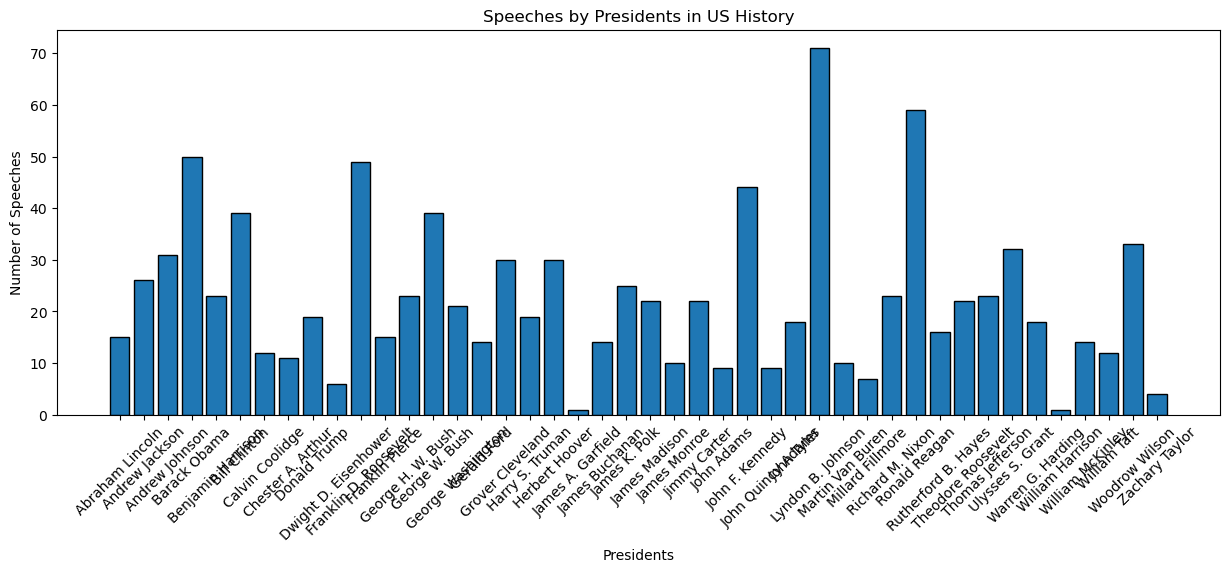

In [11]:
#simple visualization on speeches by president
by_president = speeches.groupby('President').count()['Transcript']

plt.figure(figsize=(15,5))
plt.bar(by_president.index, by_president.values, edgecolor='black')
plt.xlabel('Presidents')
plt.ylabel('Number of Speeches')
plt.title('Speeches by Presidents in US History')
plt.xticks(rotation=45)
plt.show()

In [12]:
#initialize lemmatization on each speech, can analyze without context. Then count vectorize etc. 

df = speeches[['Party', 'Transcript']]

print("Parties to Analyze:", df['Party'].unique())

##split into parties

df_rep = df[df['Party'] == 'Republican']

df_rep.head(n=5)

df_dem = df[df['Party'] == 'Democratic']

df_dem.head(n=5)

Parties to Analyze: ['Unaffiliated' 'Federalist' 'Democratic-Republican' 'Democratic' 'Whig'
 'Republican']


,Party,Transcript
93,Democratic,Fellow Citizens: About to undertake the arduou...
94,Democratic,Whereas by an act of the Congress of the Unite...
95,Democratic,Fellow citizens of the Senate and House of Rep...
96,Democratic,To the Senate of the United States. The accomp...
97,Democratic,To the House of Representatives. I have mature...


In [13]:
#example
dem_lst = list(df_dem['Transcript'])

#clearly no issues of newline removal here


In [14]:
#count unique, analyze words

stop_words = set(stopwords.words('english')) #add punctuation, using 'add'

addon = [',', '.', "'s", "n't", '(', ')', "'ve", "'re", ':', '?', '!', ';', '“','”', "'ll"]

for e in addon: 
    stop_words.add(e)
# stop_words.add('.')

def wordtoken(x, sw= None, n = 10): 
    #just for separation and viewing
    #tokenize, count
    token = word_tokenize(x.lower())

    token_r = [word for word in token if word not in sw]

    ct = Counter(token_r)

    #add lemma

    # output 
    print('Total words in the text:', sum(ct.values()))
    print('Top 10 words by frequency:\n', ct.most_common(n))
    

In [15]:
%%capture
#dem
for speech, value in zip(df_dem['Transcript'], df_dem["Party"]):
    print(value) #adjust to something else more informative, like name, year. Re-take columns from before
    wordtoken(speech, sw = stop_words, n = 10)

In [16]:
%%capture
#rep
for speech1, value1 in zip(df_rep['Transcript'], df_rep["Party"]):
    print(value1) #adjust to something else more informative, like name, year. Re-take columns from before
    wordtoken(speech1, sw = stop_words, n = 10)

In [17]:
print(df_rep['Transcript'])

184    Honors To Henry ClayOn the fourth day of July,...
194    The repeal of the Missouri Compromise, and the...
205    Mr. PRESIDENT and Gentlemen of the Convention....
210    Mr. President and fellow citizens of New York:...
217    My friends No one, not in my situation, can ap...
                             ...                        
986    Just a short time ago, I had the honor of pres...
987    Madam Speaker, Mr. Vice President, Members of ...
988    Thank you very much, everybody. Before we begi...
989    Thank you very much. Mr. President, Mr. Secret...
990    Thank you very much. Thank you. Well, thank yo...
Name: Transcript, Length: 389, dtype: object


### Tfidf Vectorization -> Clustering, etc

In [18]:
import textwrap

In [19]:
#instantiate master list of speeches

##all
all = [speech for speech in df['Transcript']] 

party = [p for p in df['Party']] 

# select
df.Party.value_counts()

Party
Democratic               478
Republican               389
Democratic-Republican     64
Unaffiliated              39
Whig                      12
Federalist                 9
Name: count, dtype: int64

In [20]:
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    
    presidentvectorizer = TfidfVectorizer(
    strip_accents='unicode',
    stop_words = 'english',
    lowercase=True,
    min_df=2,
    max_df=0.8, 
    binary=False, 
    norm='l2',
    use_idf=True,
)
    
    return presidentvectorizer

In [21]:
pre = pre_proc(all)

pre.fit(all)
    
output_matrix = pre.fit_transform(all)

print("Matrix shape: {}".format(output_matrix.shape))
    
#take the second document and print
features_1 = pre.get_feature_names_out(all[2][0:20])
print("Random Document:", all[2])
print("Random Document Features: {}".format(features_1))


Matrix shape: (991, 23786)
Random Document: Fellow Citizens of the Senate and House of Representatives: I embrace with great satisfaction the opportunity which now presents itself, of congratulating you on the present favourable prospects of our public affairs. The recent accession of the important State of North Carolina to the Constitution of the United States ( of which official information has been received ); the rising credit and respectability of our Country; the general and increasing good will towards the Government of the Union, and the concord, peace, and plenty, with which we are blessed are circumstances auspicious in an eminent degree, to our national prosperity. In resuming your consultations for the general good, you can not but derive encouragement from the reflection that the measures of the last Session have been as satisfactory to your Constituents, as the novelty and difficulty of the work allowed you to hope. Still further to realize their expectations and to secu

#### Clustering

Text(0.5, 1.0, 'All — K Means')

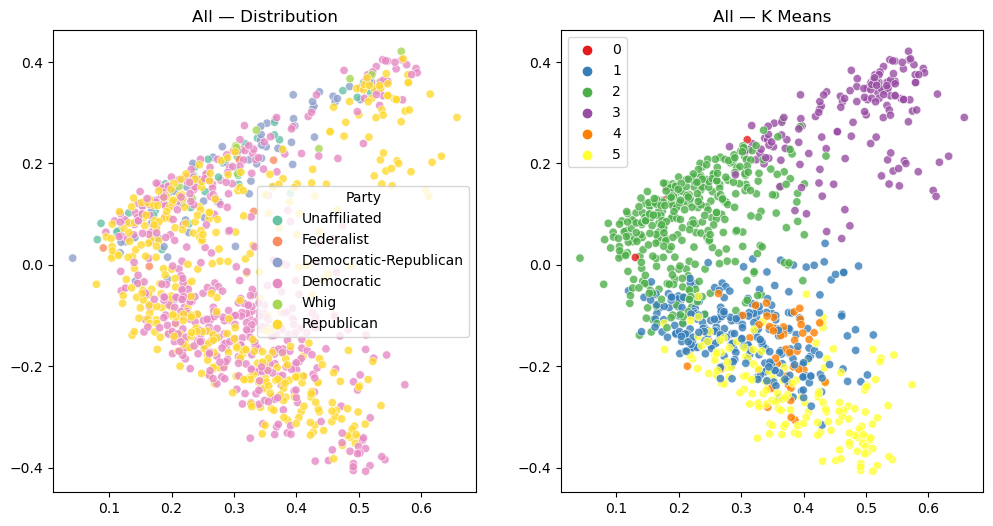

In [22]:
#no k means, shows mix

import seaborn as sns
X_reduced = TruncatedSVD().fit_transform(output_matrix)

y_pred = KMeans(n_clusters=6, random_state= 42, n_init='auto').fit(output_matrix)

plt.figure(figsize = (12,6))

plt.subplot(121)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=df['Party'], alpha=0.8, palette='Set2')
plt.title("All — Distribution")

plt.subplot(122)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y_pred.predict(output_matrix), hue_order=[0, 1, 2, 3, 4, 5], alpha=0.8, palette='Set1')
plt.title("All — K Means")

In [23]:

y_pred = KMeans(n_clusters=6, random_state= 42, n_init='auto').fit(output_matrix)

ylabels = y_pred.predict(output_matrix)

In [24]:
from sklearn.metrics import silhouette_score

# Assuming you have already performed clustering and obtained cluster labels
# X is your feature matrix, and cluster_labels is the array of cluster labels assigned by the clustering algorithm

# Compute silhouette score
silhouette_avg = silhouette_score(output_matrix, ylabels)

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.012112991082925954


In [25]:
y_pred2 = KMeans(n_clusters=6, random_state= 42, n_init='auto')

y_pred2.fit(output_matrix)

y_pred2.inertia_

yp = y_pred2.labels_

In [26]:
text_cluster_mapping = {}
for i, label in enumerate(yp):
    if label not in text_cluster_mapping:
        text_cluster_mapping[label] = []
    text_cluster_mapping[label].append(df['Party'][i])  # Using 'i' to directly access the text

In [27]:
zero, one, two, three, four, five = [text_cluster_mapping[i] for i in range(6)]

total = [zero, one, two]
for position, list in enumerate(total): 
    element_counts = Counter(list)
    print("Cluster:", position)

    # Print the counts of each unique element
    for element, count in element_counts.items():
        print(f"Element {element} occurs {count} times")
    print('')


Cluster: 0
Element Democratic occurs 3 times
Element Republican occurs 1 times

Cluster: 1
Element Republican occurs 98 times
Element Democratic occurs 155 times

Cluster: 2
Element Unaffiliated occurs 29 times
Element Federalist occurs 6 times
Element Democratic-Republican occurs 36 times
Element Democratic occurs 159 times
Element Whig occurs 7 times
Element Republican occurs 136 times



In [28]:
total = [three, four, five]
for position, list in enumerate(total): 
    element_counts = Counter(list)
    print("Cluster:", position + 3)

    # Print the counts of each unique element
    for element, count in element_counts.items():
        print(f"Element {element} occurs {count} times")
    print('')

Cluster: 3
Element Unaffiliated occurs 10 times
Element Federalist occurs 3 times
Element Democratic-Republican occurs 28 times
Element Democratic occurs 48 times
Element Whig occurs 5 times
Element Republican occurs 61 times

Cluster: 4
Element Republican occurs 13 times
Element Democratic occurs 34 times

Cluster: 5
Element Democratic occurs 79 times
Element Republican occurs 80 times



Having analyzed our clusters, in all time speeches, we can clearly see, that there is an interesting, not necessarily defined mix of party speeches. This merits further investigation.

### Party Systems

In [29]:
#work into a function (less code)
from sklearn.metrics import silhouette_score

def partysystems(prezs, title1, title2, clusters_num): 
    fparty = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in prezs]

    clr = [party for president, party in zip(speeches['President'], speeches['Party']) if president in prezs]


    first = pre_proc(fparty)
        
    first_party = first.fit_transform(fparty)

    firstx = TruncatedSVD().fit_transform(first_party)

    first_pred = KMeans(n_clusters=clusters_num, random_state= 42, n_init='auto').fit(first_party)

    yy = first_pred.predict(first_party)

    silhouette_avg = silhouette_score(first_party, yy)

    print("Silhouette Score:", silhouette_avg)

    plt.figure(figsize = (12,6))

    plt.subplot(121)
    sns.scatterplot(x=firstx[:,0], y=firstx[:,1], hue=clr, alpha=0.8, palette='Set1')
    plt.title(title1)

    plt.subplot(122)
    sns.scatterplot(x=firstx[:,0], y=firstx[:,1], hue=first_pred.predict(first_party), alpha=0.8, palette='Set1')
    plt.title(title2)

Silhouette Score: 0.018371948878673886
Silhouette Score: 0.034377886695605556
Silhouette Score: 0.025687672680264933
Silhouette Score: 0.039962744115788255
Silhouette Score: 0.015229075133576436
Silhouette Score: 0.010923134427992589


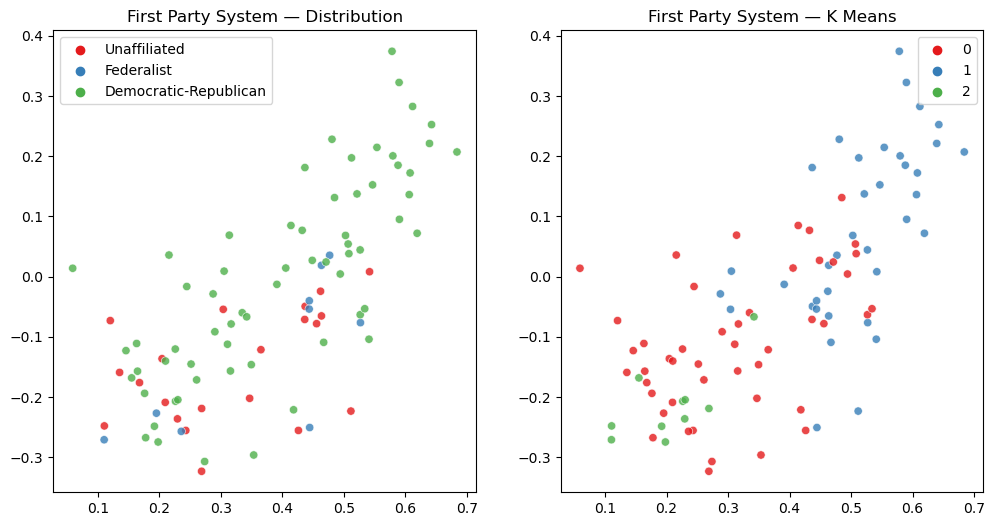

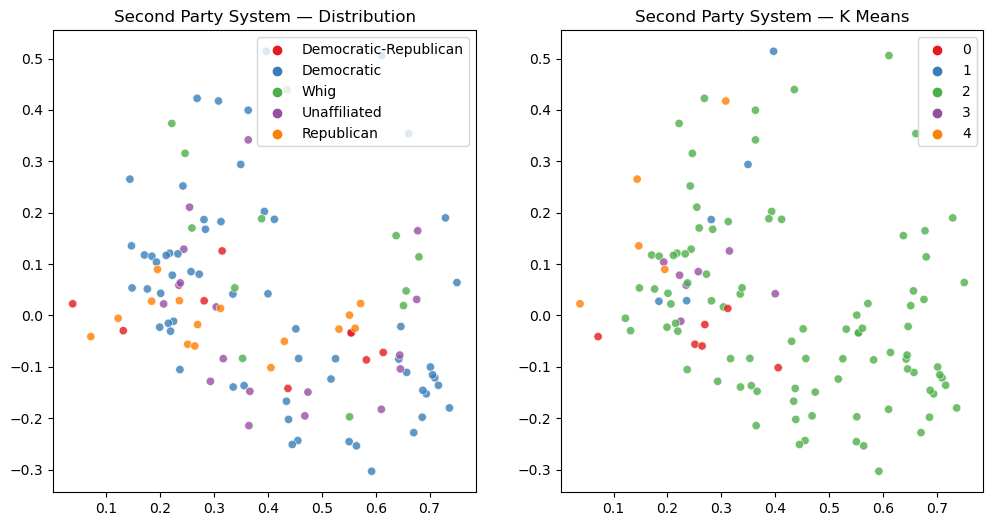

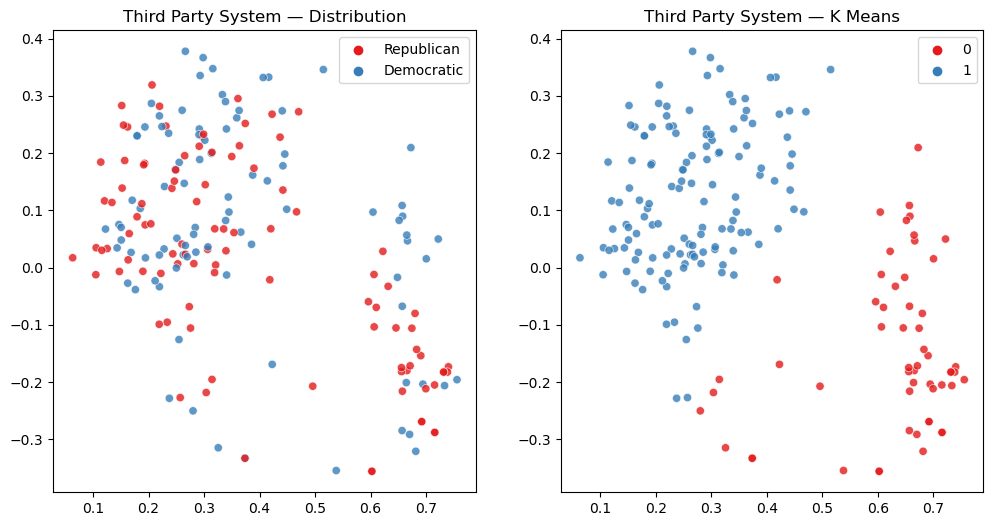

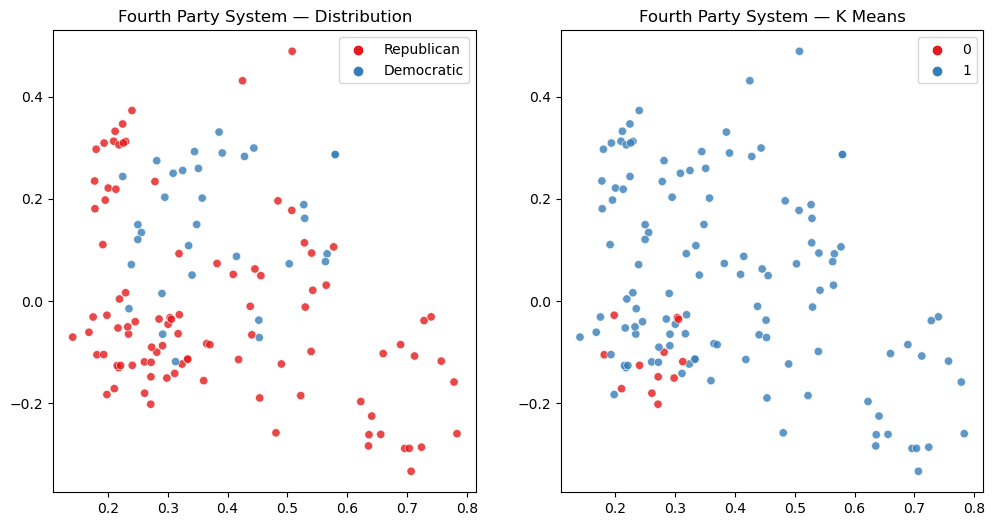

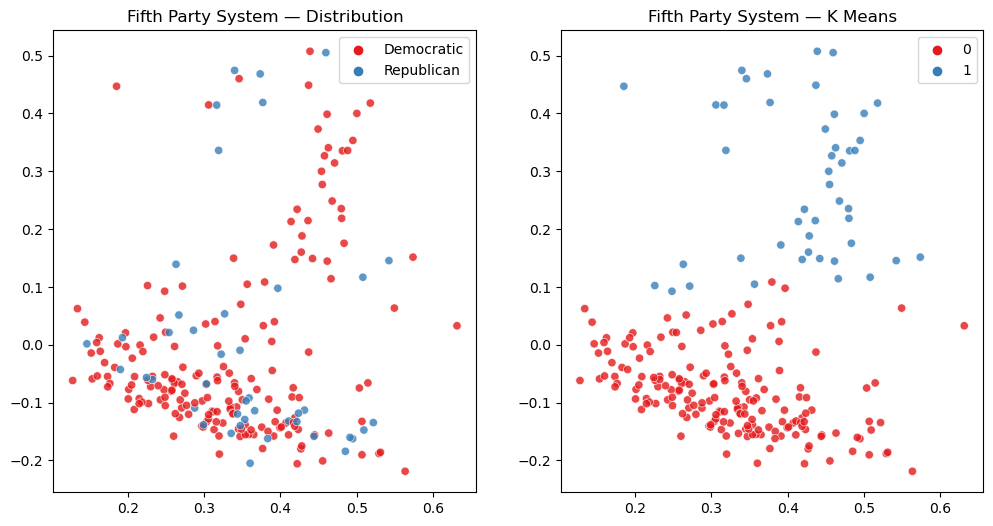

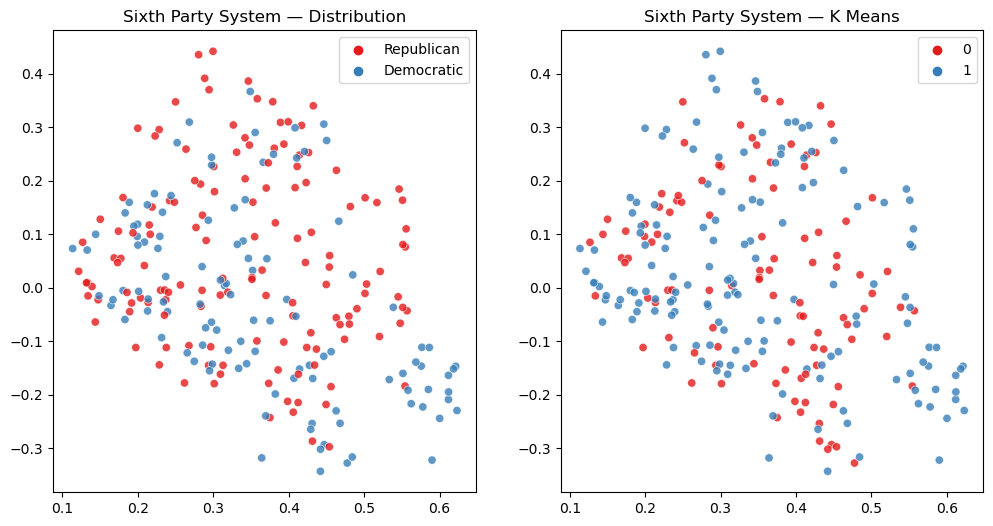

In [30]:
first_party = ['George Washington', 'John Adams', 'Thomas Jefferson', 'James Madison', 'James Monroe', 'John Quincy Adams']

partysystems(first_party, 'First Party System — Distribution', 'First Party System — K Means', 3)

second_party = ['John Quincy Adams', 'Andrew Jackson', 'Martin Van Buren', 'William Harrison', 'John Tyler', 'James K. Polk', 'Zachary Taylor', 'Millard Fillmore', 'Abraham Lincoln']

partysystems(second_party, 'Second Party System — Distribution', 'Second Party System — K Means', 5)

third_party = ['Franklin Pierce', 'James Buchanan', 'Abraham Lincoln', 'Andrew Johnson', 'Ulysses S. Grant', 'Rutherford B. Hayes', 'James A. Garfield', 'Chester A. Arthur', 'Grover Cleveland', 'Benjamin Harrison']

partysystems(third_party, 'Third Party System — Distribution', 'Third Party System — K Means', 2)

fourth_party = ['William McKinley', 'William Taft', 'Woodrow Wilson', 'Warren G. Harding', 'Calvin Cooldige', 'Herbert Hoover', 'Theodore Roosevelt']

partysystems(fourth_party, 'Fourth Party System — Distribution', 'Fourth Party System — K Means', 2)

fifth_party = ['Franklin D. Roosevelt', 'Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard M. Nixon', 'Gerald Ford'] #added Gerald Ford

partysystems(fifth_party, 'Fifth Party System — Distribution', 'Fifth Party System — K Means', 2)

sixth_party = ['Jimmy Carter', 'Ronald Reagan', 'George H. W. Bush', 'Bill Clinton', 'George W. Bush', 'Barack Obama', 'Donald Trump'] #removed Lyndon B. Johnson', 'Richard M. Nixon', 'Gerald Ford', 
partysystems(sixth_party, 'Sixth Party System — Distribution', 'Sixth Party System — K Means', 2)

<Axes: xlabel='Cluster Label'>

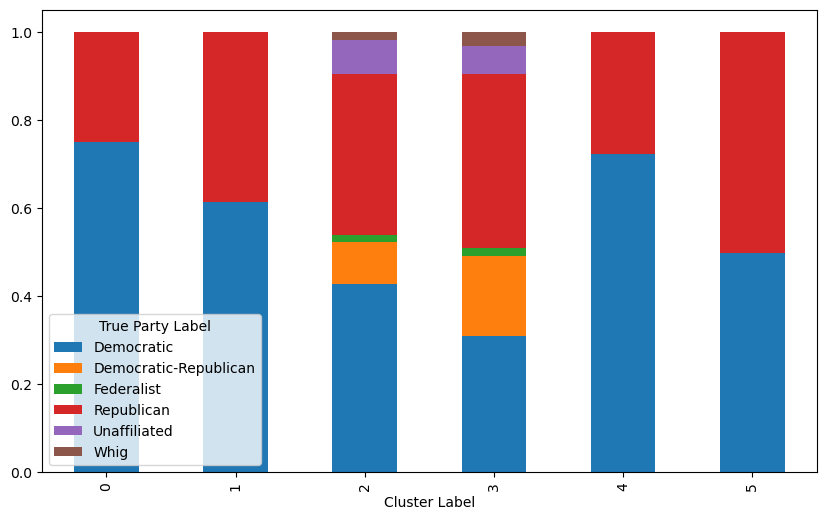

In [31]:
df0 = pd.DataFrame({
    'Data Point ID': range(1, len(ylabels) + 1),  # Assuming IDs start from 1
    'Cluster Label': ylabels,
    'True Party Label': party
})

cluster_party_counts = df0.groupby(['Cluster Label', 'True Party Label']).size().unstack(fill_value=0)

cluster_party_proportions = cluster_party_counts.div(cluster_party_counts.sum(axis=1), axis=0)

# Plot stacked bar chart
cluster_party_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

### Scoring in the Sixth Party System — Initial Tokenization Attempt

In [32]:
oe = ['Lyndon B. Johnson', 'Richard M. Nixon', 'Gerald Ford', 'Jimmy Carter', 'Ronald Reagan', 'George H. W. Bush', 'Bill Clinton', 'George W. Bush', 'Barack Obama', 'Donald Trump']
obamaera_s = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in oe]

obamaera_p = [party for president, party in zip(speeches['President'], speeches['Party']) if president in oe]

obamaera_d = [date for president, date in zip(president_csv['President'], president_csv['Date']) if president in oe]

obamaera_pi = [president for president in speeches['President'] if president in oe]

oe_df = pd.DataFrame({'name':obamaera_pi, 'date': obamaera_d, 'party' : obamaera_p, 'speech': obamaera_s})

oe_df_r = oe_df[oe_df['party'] == 'Republican'] #republican df

oe_df_d = oe_df[oe_df['party'] == 'Democratic'] #democrat df

oe_df['party'].value_counts()



party
Democratic    182
Republican    177
Name: count, dtype: int64

In [33]:
#add necessary — for some reason excluded — stopwords to the set
added_words = {'going', 'said', 'think', 'also', 'q', 'like', 'would', 'look', 'ca', 'well', 'get', 'things', 'could', 'thought', 'got', 'make', 'look', 'good'}

stop_words.update(added_words)

In [34]:
#nwords — republican tokens, most 200 common
for speech in oe_df_r['speech']:
    o = word_tokenize(speech.lower())
    otoken = [word for word in o if word not in stop_words]
    oct = Counter(otoken)
    final = oct.most_common(200)
    
    nwords = []
    for a in final: 
        nwords.append(a[0])

nwords

tokenized_speeches = [word_tokenize(s.lower()) for s in oe_df_r['speech']]

# Assign the tokenized speeches to a new column 'token' in the DataFrame
oe_df_r['token'] = tokenized_speeches

ss = []

for s in oe_df_r['speech']: 
    speech_score = sum(1 for token in s if token in nwords)
    
    if len(s) != 0:
        ss.append(100*(speech_score / len(s)))
    else:
        ss.append(0)

analyzer = pd.DataFrame({'name':oe_df_r['name'], 'date': oe_df_r['date'], 'score': ss})


analyzer['date'] = pd.to_datetime(analyzer['date'])

analyzer 


,name,date,score
0,Richard M. Nixon,1952-09-23,0.161780
21,Ronald Reagan,1964-10-27,0.092297
73,Richard M. Nixon,1969-01-20,0.000000
74,Richard M. Nixon,1969-11-03,0.054037
75,Richard M. Nixon,1970-01-22,0.118694
...,...,...,...
354,Donald Trump,2019-01-19,0.033061
355,Donald Trump,2019-02-05,0.114413
356,Donald Trump,2019-02-15,0.102107
357,Donald Trump,2019-09-24,0.038554


In [35]:
#nwordsd, democrat tokens
for speech in oe_df_d['speech']:
    o = word_tokenize(speech.lower())
    otoken = [word for word in o if word not in stop_words]
    oct = Counter(otoken)
    final = oct.most_common(200)
    
    nwordsd = []
    for a in final: 
        nwordsd.append(a[0])

nwordsd

tokenized_speeches3 = [word_tokenize(s.lower()) for s in oe_df_d['speech']]

# Assign the tokenized speeches to a new column 'token' in the DataFrame
oe_df_d['token'] = tokenized_speeches3

ss3 = []

for s in oe_df_d['speech']: 
    speech_score3 = sum(1 for token in s if token in nwordsd)
    
    if len(s) != 0:
        ss3.append(-(100*(speech_score3 / len(s))))
    else:
        ss3.append(0)
    

analyzer3 = pd.DataFrame({'name':oe_df_d['name'], 'date': oe_df_d['date'], 'score': ss3})

analyzer3['date'] = pd.to_datetime(analyzer3['date'])

analyzer3 

print(final)


[('laughter', 32), ('world', 21), ('better', 18), ('know', 15), ('one', 14), ('america', 14), ('years', 13), ('want', 13), ('1', 12), ('history', 11), ('right', 11), ('progress', 10), ('change', 10), ('much', 9), ('take', 9), ('every', 9), ('people', 9), ('class', 8), ('made', 8), ('generation', 8), ('nation', 8), ('great', 8), ('country', 8), ('economy', 8), ('help', 8), ('rutgers', 7), ('first', 7), ('even', 7), ('sure', 7), ('ago', 7), ('new', 7), ('always', 7), ('believe', 7), ('point', 7), ('since', 7), ('work', 7), ('time', 7), ('americans', 7), ('wo', 7), ('facts', 7), ('somebody', 7), ('say', 6), ('reason', 6), ('debate', 6), ('college', 6), ('big', 6), ('back', 6), ('long', 6), ('sometimes', 6), ('may', 6), ('us', 6), ('everything', 6), ('way', 6), ('vote', 6), ('thank', 5), ('dr.', 5), ('2016', 5), ('lot', 5), ('really', 5), ('old', 5), ('folks', 5), ('day', 5), ('school', 5), ('hard', 5), ('times', 5), ('human', 5), ('changes', 5), ('war', 5), ('seen', 5), ('past', 5), ('exa

In [36]:
#initialize new colors
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 0.5, 0.5), (1, 0, 0)]
colors2 = [(0, 0, 1), (0.5, 0.5, 1)] 

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_red', colors)
custom_cmap2 = LinearSegmentedColormap.from_list('custom_blue', colors2)

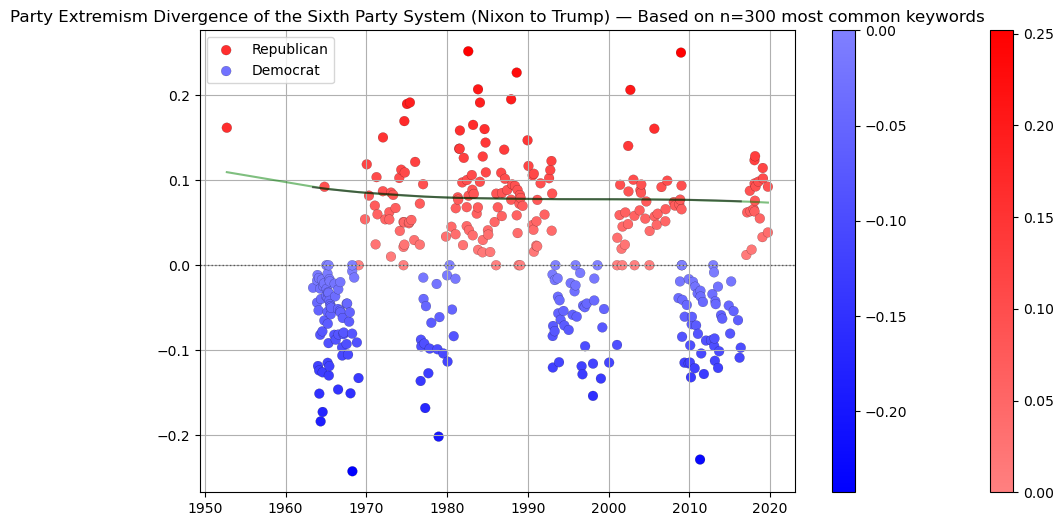

In [37]:
x_values = analyzer['date'].map(lambda x: x.toordinal())

coefficients = np.polyfit(x_values, analyzer['score'], 3)
poly = np.poly1d(coefficients)

x_values2 = analyzer3['date'].map(lambda x: x.toordinal())

coefficients2 = np.polyfit(x_values2, analyzer3['score'], 1)
poly2 = np.poly1d(coefficients2)

plt.figure(figsize=(12,6))
plt.scatter(analyzer['date'], analyzer['score'], c=analyzer['score'], alpha=1, s=50, cmap = custom_cmap, edgecolors= 'black', linewidths = .1, label = 'Republican')
plt.colorbar()
plt.scatter(analyzer3['date'], analyzer3['score'], c=analyzer3['score'], alpha=1, s=50, cmap = custom_cmap2, edgecolors= 'black', linewidths = .1, label = 'Democrat')
plt.legend()

plt.axhline(0, color='black', linewidth=1, alpha=.5, linestyle = 'dotted')

plt.plot(analyzer['date'], poly(x_values), color='green', label='Line of Best Fit', alpha = .5)
plt.plot(analyzer3['date'], poly(x_values2), color='black', label='Line of Best Fit', alpha = .5)

plt.grid(True)
plt.colorbar()
plt.title('Party Extremism Divergence of the Sixth Party System (Nixon to Trump) — Based on n=300 most common keywords')


plt.show()

In [38]:
nwords #REPUBLICAN

nwordsd #DEMOCRAT

tokenized_speeches_all = [word_tokenize(s.lower()) for s in oe_df['speech']]

# Assign the tokenized speeches to a new column 'token' in the DataFrame
oe_df['token'] = tokenized_speeches_all

ss_all = []

for s in oe_df['speech']: 
    speech_score_all = sum(1 if token in nwords else -1 if token in nwordsd else 0 for token in s)
    
    if len(s) != 0:
        ss_all.append(100*(speech_score_all / len(s)))
    else:
        ss_all.append(0)

analyzer_all = pd.DataFrame({'name':oe_df['name'], 'date': oe_df['date'], 'score': ss_all})

analyzer_all['date'] = pd.to_datetime(analyzer_all['date'])

analyzer_all 


,name,date,score
0,Richard M. Nixon,1952-09-23,0.161780
1,Lyndon B. Johnson,1963-05-30,0.026539
2,Lyndon B. Johnson,1963-11-27,0.044092
3,Lyndon B. Johnson,1963-11-28,0.017995
4,Lyndon B. Johnson,1963-12-17,0.011570
...,...,...,...
354,Donald Trump,2019-01-19,0.033061
355,Donald Trump,2019-02-05,0.114413
356,Donald Trump,2019-02-15,0.102107
357,Donald Trump,2019-09-24,0.038554


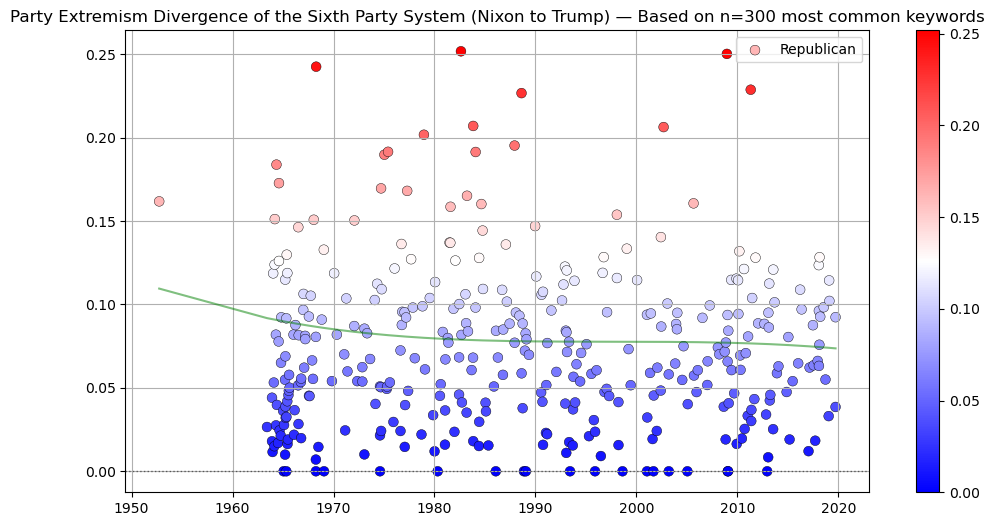

In [39]:
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]

# Create a LinearSegmentedColormap object
cmap0 = LinearSegmentedColormap.from_list('BlueWhiteRed', colors)


x_all = analyzer_all['date'].map(lambda x: x.toordinal())

coefficients_all = np.polyfit(x_all, analyzer_all['score'], 3)
poly_all = np.poly1d(coefficients_all)


plt.figure(figsize=(12,6))
plt.scatter(analyzer_all['date'], analyzer_all['score'], c=analyzer_all['score'], alpha=1, s=50, cmap = cmap0, edgecolors= 'black', linewidths = .3, label = 'Republican')
# plt.scatter(analyzer3['date'], analyzer3['score'], c=analyzer3['score'], alpha=1, s=50, cmap = custom_cmap2, edgecolors= 'black', linewidths = .1, label = 'Democrat')
plt.legend()

plt.axhline(0, color='black', linewidth=1, alpha=.5, linestyle = 'dotted')

plt.plot(analyzer_all['date'], poly(x_all), color='green', label='Line of Best Fit', alpha = .5)
plt.colorbar()

plt.grid(True)
plt.title('Party Extremism Divergence of the Sixth Party System (Nixon to Trump) — Based on n=300 most common keywords')


plt.show()

### Fightin Words

In [40]:
import fightinwords as fw
from   sklearn.feature_extraction.text import CountVectorizer

In [41]:
vectorizer = CountVectorizer( # set up a vectorizer
    lowercase=True,
    strip_accents='unicode',
    stop_words = 'english',
    input='content',
    encoding='utf-8',
)


def display_fw(data, n=10, name1='corpus one', name2='corpus two'):
    '''Display the indicated number of top terms from fightinwords output.'''
    print("Top terms in", name1)
    for term, score in reversed(data[-n:]):
        print(f"{term:<10} {score:6.3f}")
    print("")
    print("Top terms in", name2)
    for term, score in data[:n]:
        print(f"{term:<10} {score:6.3f}")

In [42]:
#democrat string of speeches
democrat_six = [speech for speech in oe_df_d['speech']]

#repubican string of speeches
repub_six = [speech for speech in oe_df_r['speech']]

In [43]:
flat = fw.bayes_compare_language(democrat_six, repub_six)
display_fw(flat, name1="Democratic Speeches", name2="Republican Speeches")

Vocab size is 5242
Comparing language...
Top terms in Democratic Speeches
vietnam    13.896
health     10.175
care       10.024
college     9.886
carter      9.772
education   9.209
south       9.195
businesses  9.150
governor    9.051
ford        8.874

Top terms in Republican Speeches
soviet     -11.168
iraq       -10.722
terrorists -9.712
iraqi      -9.561
border     -9.102
missiles   -9.021
bush       -8.688
strategic  -8.028
theyre     -7.941
lebanon    -7.788


In [44]:
#fps speech corpus
fifth_speeches = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in fifth_party]

fifth_p = [party for president, party in zip(speeches['President'], speeches['Party']) if president in fifth_party]

#repub
republican_speeches = [speech for speech, party in zip(fifth_speeches, fifth_p) if party == 'Republican']

#dem
democrat_speeches = [speech for speech, party in zip(fifth_speeches, fifth_p) if party == 'Democratic']



In [45]:
import scipy
from scipy.sparse import vstack

In [46]:
#GENERAL PRIOR 
priors = np.sum(vectorizer.fit_transform(fifth_speeches), axis=0).reshape(-1,1)
print(priors.shape)


(16155, 1)


In [47]:


#DIRECT PRIOR

# from sklearn.feature_extraction.text import CountVectorizer

# # Step 3: Vectorize Data
# vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode', ngram_range=(1, 1))

# # Fit-transform Democrat speeches
# democrat_matrix = np.sum(vectorizer.fit_transform(democrat_speeches), axis=0).reshape(-1,1)

# print(democrat_matrix.shape)

# # Fit-transform Republican speeches
# republican_matrix = np.sum(vectorizer.fit_transform(republican_speeches), axis = 0).reshape(-1,1)
# print(republican_matrix.shape)


# # Step 4: Combine Matrices
# final_matrix = np.vstack([democrat_matrix, republican_matrix])

# print(final_matrix.shape)

In [48]:
import scipy
from scipy.sparse import vstack

In [49]:
## use transform to maintain consistency with original vocab
# Vectorize Republican speeches
republican_matrix2 = vectorizer.transform(repub_six)

republican_aggregated = np.sum(republican_matrix2, axis=0)  # You can also use np.mean() if needed

rr = republican_aggregated.reshape(1, -1)

# Vectorize 

democrat_matrix2 = vectorizer.transform(democrat_six)

democrat_aggregated = np.sum(democrat_matrix2, axis=0)  # You can also use np.mean() if needed

dr = democrat_aggregated.reshape(1, -1)

# Stack 
party_matrix = np.vstack([dr, rr])

print(f"Shape: {party_matrix.shape}, 2 parties by total vocab size")

Shape: (2, 16155), 2 parties by total vocab size


In [50]:
informative = fw.bayes_compare_language(
    l1=[0], 
    l2=[1], 
    features=party_matrix, 
    cv=vectorizer, 
    prior=priors
    #prior_weight=10 <- optional normalize and reweight the data
)
display_fw(informative, name1= "Democrat", name2 = "Republican")

Vocab size is 16155
Comparing language...
Top terms in Democrat
carter     10.194
ford        9.540
think       9.468
businesses  9.309
care        9.299
college     9.152
health      9.142
viet        8.781
nam         8.690
president   8.351

Top terms in Republican
iraq       -11.824
terrorists -9.324
iraqi      -9.263
soviet     -8.975
freedom    -8.815
bush       -8.478
border     -8.378
missiles   -8.136
lebanon    -8.092
drug       -7.253


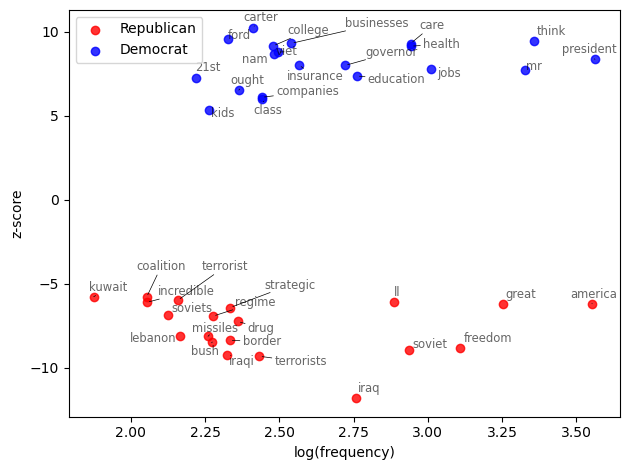

In [51]:
from   adjustText import adjust_text # pretty, but not included with class environment
                                     # conda install -c conda-forge adjusttext 
import matplotlib.pyplot as plt
import pandas as pd

# convert to dataframe for convenience
df = pd.DataFrame(party_matrix, columns=vectorizer.get_feature_names_out())

num_words_to_plot = 20 # number of most distinctive words to plot from each corpus

 # manage data for plotting
frequencies = []
zscores = []
words = []
for word, z_score in informative:
    count = df[word].sum()
    if count > 0:
        zscores.append(z_score)
        words.append(word)
        frequencies.append(count)

# plot result
texts = []
fig, ax = plt.subplots(1,1)
ax.scatter(
    np.log10(frequencies[:num_words_to_plot]), 
    zscores[:num_words_to_plot], 
    alpha=0.8, 
    label="Republican", 
    color='red'
)
ax.scatter(
    np.log10(frequencies[-num_words_to_plot:]), 
    zscores[-num_words_to_plot:], 
    alpha=0.8, 
    color = 'blue',
    label="Democrat"
)
for i in range(-num_words_to_plot, num_words_to_plot):
    texts.append(ax.text(np.log10(frequencies[i]), zscores[i], words[i], size='small', alpha=0.6))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.xlabel('log(frequency)')
plt.ylabel('z-score')
plt.legend()
plt.tight_layout()
plt.show()

##### Scoring per fightin words

In [52]:
# first determine weighting then just use same token thing as before

#initialize dem dict
dem_dict = {term: score for term, score in reversed(informative[-200:])}

#initialize repub dict
repub_dict = {term: score for term, score in reversed(informative[:200])}

len(repub_dict)


200

In [53]:
#scoring

ss_all_f = []

for s in oe_df['token']:
    speech_score_all = sum(dem_dict[token] if token in dem_dict else repub_dict[token] if token in repub_dict else 0 for token in s)

    if len(s) != 0:
        ss_all_f.append(100*(speech_score_all / len(s)))

ss_all_f

fightin = pd.DataFrame({'name':oe_df['name'], 'date': oe_df['date'], 'score': ss_all_f})

fightin['date'] = pd.to_datetime(fightin['date'])


In [54]:
fightin

,name,date,score
0,Richard M. Nixon,1952-09-23,5.076533
1,Lyndon B. Johnson,1963-05-30,4.454279
2,Lyndon B. Johnson,1963-11-27,5.814397
3,Lyndon B. Johnson,1963-11-28,2.339618
4,Lyndon B. Johnson,1963-12-17,-9.360219
...,...,...,...
354,Donald Trump,2019-01-19,-17.695577
355,Donald Trump,2019-02-05,-8.639886
356,Donald Trump,2019-02-15,-10.202383
357,Donald Trump,2019-09-24,-20.204606


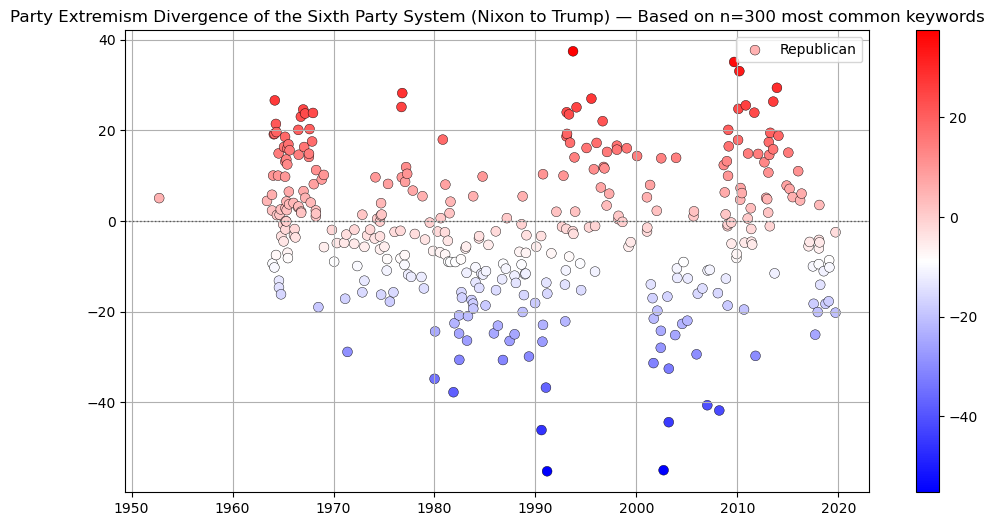

In [55]:
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]

# Create a LinearSegmentedColormap object
cmap0 = LinearSegmentedColormap.from_list('BlueWhiteRed', colors)


# x_all = analyzer_all['date'].map(lambda x: x.toordinal())

# coefficients_all = np.polyfit(x_all, analyzer_all['score'], 3)
# poly_all = np.poly1d(coefficients_all)


plt.figure(figsize=(12,6))
plt.scatter(fightin['date'], fightin['score'], c=fightin['score'], alpha=1, s=50, cmap = cmap0, edgecolors= 'black', linewidths = .3, label = 'Republican')
# plt.scatter(analyzer3['date'], analyzer3['score'], c=analyzer3['score'], alpha=1, s=50, cmap = custom_cmap2, edgecolors= 'black', linewidths = .1, label = 'Democrat')
plt.legend()

plt.axhline(0, color='black', linewidth=1, alpha=.5, linestyle = 'dotted')

# plt.plot(analyzer_all['date'], poly(x_all), color='green', label='Line of Best Fit', alpha = .5)
plt.colorbar()

plt.grid(True)
plt.title('Party Extremism Divergence of the Sixth Party System (Nixon to Trump) — Based on n=300 most common keywords')


plt.show()

In [56]:
vectorizer = CountVectorizer( # set up a vectorizer
    lowercase=True,
    strip_accents='unicode',
    input='content',
    encoding='utf-8',
    stop_words = 'english'
)

def fightin_change(party_system, prior_train, v= vectorizer): 
    '''
    Returns party divergence given general prior, and training systems. DOES NOT include plotting
    Arguments: 
    - party_system: The party system that is to be analyzed
    - prior_train: The party system to train on
    - v=vectorizer: The vectorizer being used
    '''
    speeches1 = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in party_system]
    parties = [party for president, party in zip(speeches['President'], speeches['Party']) if president in party_system]
    #repub
    republican_speeches = [speech for speech, party in zip(speeches1, parties) if party == 'Republican']
    #dem
    democrat_speeches = [speech for speech, party in zip(speeches1, parties) if party == 'Democratic']
    #prior
    xprior = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in prior_train]
    priors = np.sum(v.fit_transform(xprior), axis=0).reshape(-1,1) #initially fit on prior speeches

    #matrix intialization for features: 
        #republican
    republican_matrix = v.transform(republican_speeches)
    republican_aggregated = np.sum(republican_matrix, axis=0)  # You can also use np.mean() if needed
    rr = republican_aggregated.reshape(1, -1)
        #democrat
    democrat_matrix = v.transform(democrat_speeches)
    democrat_aggregated = np.sum(democrat_matrix, axis=0)  # You can also use np.mean() if needed
    dr = democrat_aggregated.reshape(1, -1)
        #aggregate
    party_matrix = np.vstack([dr, rr])
    print(f"Shape: {party_matrix.shape}, 2 parties by total vocab size")

    #express results
    if party_system == sixth_party: ##should not train this party system on the past, should be its own weight
        informative = fw.bayes_compare_language(democrat_speeches, republican_speeches)
    else:
        informative = fw.bayes_compare_language(
        l1=[0], 
        l2=[1], 
        features=party_matrix, 
        cv=vectorizer, 
        prior=priors #<- optional normalize and reweight the data
        )
    display_fw(informative, name1= "Democrat", name2 = "Republican")

    #scoring
        #initialize dem dict
    dem_dict = {term: score for term, score in reversed(informative[-200:])}

        #initialize repub dict
    repub_dict = {term: score for term, score in reversed(informative[:200])}

    return party_matrix, dem_dict, repub_dict


In [57]:
party, democrat,republican = fightin_change(sixth_party, fifth_party, v=vectorizer)

Shape: (2, 16155), 2 parties by total vocab size
Vocab size is 4263
Comparing language...
Top terms in Democrat
health     12.831
insurance  11.245
businesses 11.237
energy     10.861
carter     10.790
college    10.732
ford        9.529
education   9.472
oil         9.372
governor    8.930

Top terms in Republican
soviet     -11.031
terrorists -8.321
iraqi      -8.309
iraq       -8.297
missiles   -8.034
border     -7.729
bush       -7.487
terror     -7.467
regime     -6.834
lebanon    -6.725


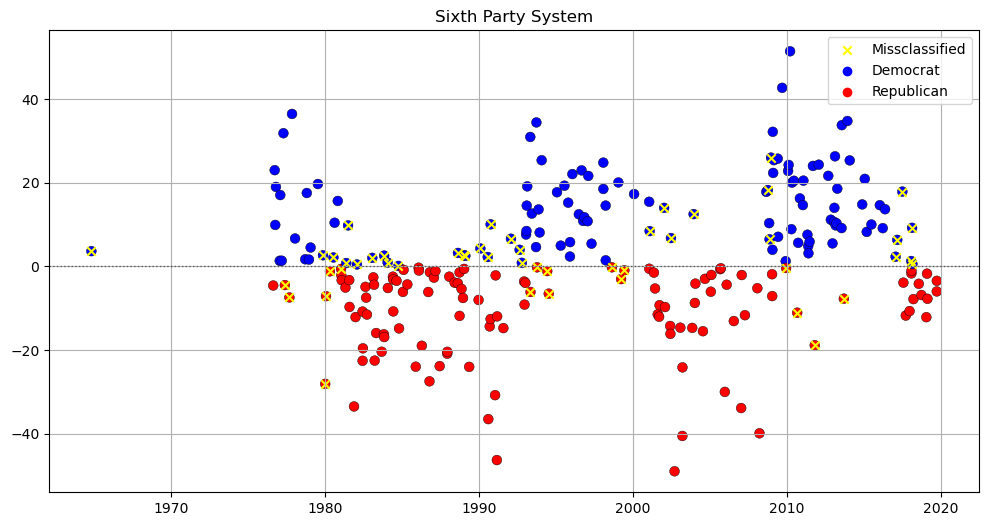

In [58]:
def fightin_scoring_plot(party_system, dict1, dict2, titlename):
    #tokenize speeches into dataframe
    speeches1 = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in party_system]
    prez = [president for president in speeches['President'] if president in party_system]
    dates = [date for president, date in zip(president_csv['President'], president_csv['Date']) if president in party_system]
    ps = [party for president, party in zip(speeches['President'], speeches['Party']) if president in party_system]
    tokenized_speeches_all = [word_tokenize(s.lower()) for s in speeches1]
    
    scores_all = []

    for ww in tokenized_speeches_all:
        speech_score_all = sum(dict1[token] if token in dict1 else dict2[token] if token in dict2 else 0 for token in ww)

        if len(ww) != 0: 
            scores_all.append(100*(speech_score_all / len(ww)))
    
    fightin = pd.DataFrame({'president': prez, 'date': dates, 'score': scores_all, 'party':ps})

    fightin['date'] = pd.to_datetime(fightin['date'])

    fightin_wrong = fightin[((fightin['score'] < 0) & (fightin['party'] == 'Democratic')) |
                        ((fightin['score'] > 0) & (fightin['party'] == 'Republican'))]



    # colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]

    colors = np.where(fightin['score'] >= 0, 'blue', 'red')

    # cmap0 = LinearSegmentedColormap.from_list('BlueWhiteRed', colors)

    # condition = ((fightin['president'] == 'Democrat') & (fightin['score'] > 0)) | ((fightin['president'] == 'Republican') & (fightin['score'] < 0))
    # condition2 = (fightin['president'] == 'Democrat')

    plt.figure(figsize=(12,6))
    plt.scatter(fightin['date'], fightin['score'], c= colors, alpha=1, s=50, edgecolors= 'black', linewidths = .3)
    plt.scatter(fightin_wrong['date'], fightin_wrong['score'], color='yellow', marker= 'x', label='Missclassified')
    plt.scatter([], [], color='blue', label='Democrat')
    plt.scatter([], [], color='red', label='Republican')
    plt.legend()
    plt.axhline(0, color='black', linewidth=1, alpha=.5, linestyle = 'dotted')
    # plt.colorbar()
    plt.grid(True)
    plt.title(titlename)
    plt.show()

    return fightin, fightin_wrong


sixpartydf, ee = fightin_scoring_plot(sixth_party, democrat, republican, "Sixth Party System")
#this needs to be trained on the initial system
    

In [59]:
sixpartydf[sixpartydf['president'] == 'George W. Bush']

bush_df = sixpartydf[sixpartydf['president'] == 'George W. Bush']

# Calculate the average of his scores in the 'scores' column
bush_avg_score = bush_df['score'].mean()

bush_avg_score

-8.231735527506762

In [60]:
p ,demo,repu = fightin_change(fifth_party, sixth_party, v=vectorizer)

Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 19542
Comparing language...
Top terms in Democrat
men        11.718
shall       8.412
labor       7.666
communist   7.439
war         6.999
think       6.947
germany     6.921
viet        6.764
south       6.592
ambassador  6.468

Top terms in Republican
ve         -10.512
america    -9.263
energy     -9.041
watergate  -6.976
oil        -6.338
thank      -5.888
ll         -5.624
jobs       -5.529
inflation  -5.282
iraq       -5.199


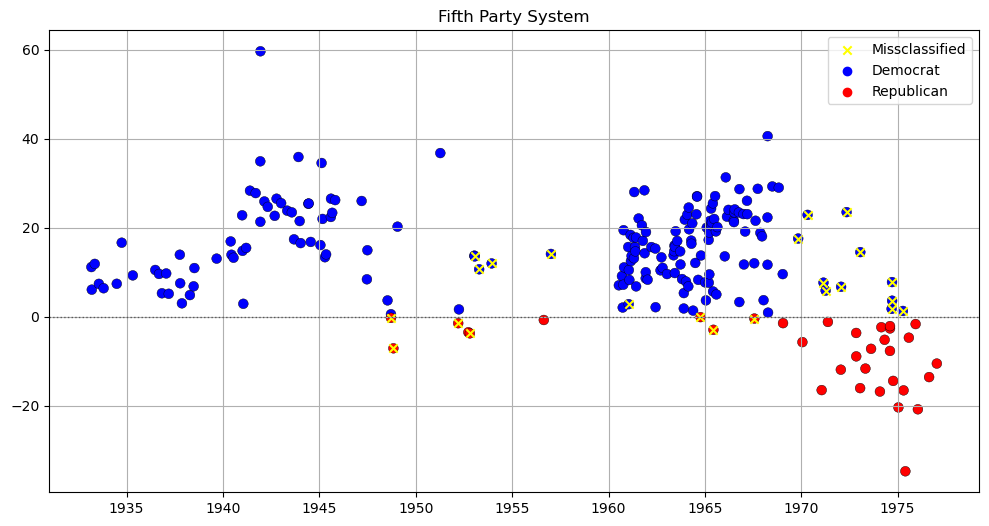

In [61]:
fivepartydf, wrongfive = fightin_scoring_plot(fifth_party, demo, repu, "Fifth Party System")

Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 19542
Comparing language...
Top terms in Democrat
ve         11.992
america    11.499
know       10.572
people      9.146
want        8.612
americans   8.487
going       8.470
let         8.381
thank       8.086
don         7.981

Top terms in Republican
public     -13.646
department -12.477
tariff     -12.322
government -12.299
commission -12.255
000        -11.984
republic   -11.715
panama     -11.373
canal      -11.184
commerce   -11.125


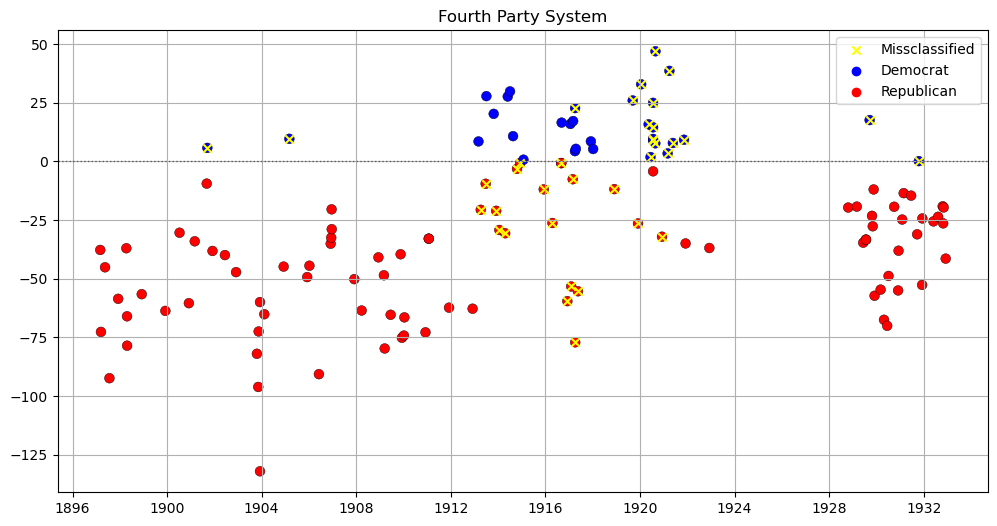

In [62]:
a, demo2,repu2 = fightin_change(fourth_party, sixth_party, v=vectorizer)
fourthpartydf, wrongfour = fightin_scoring_plot(fourth_party, demo2, repu2, "Fourth Party System")


Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 19542
Comparing language...
Top terms in Democrat
constitution  9.075
examination  8.999
kansas      8.450
classified  7.551
gold        6.590
objects     5.950
legislative  5.896
power       5.743
notes       5.694
rebellion   5.584

Top terms in Republican
slavery    -11.787
missouri   -9.643
slave      -9.123
attention  -8.519
nebraska   -8.451
compromise -7.744
indian     -7.633
slaves     -7.209
products   -6.522
clay       -6.495


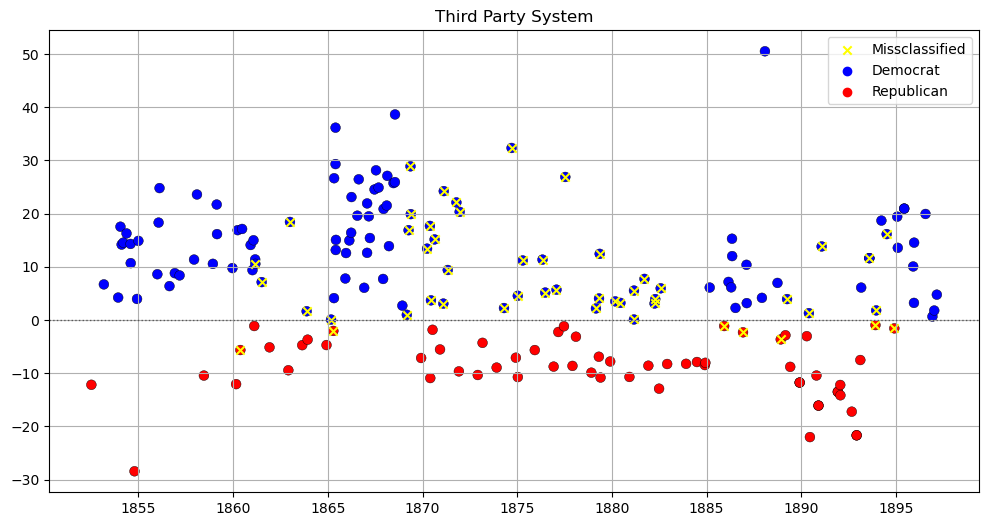

In [63]:
a, demo3,repub3 = fightin_change(third_party, sixth_party, v=vectorizer)
thirdpartydf, wrongthree = fightin_scoring_plot(third_party, demo3, repub3, "Third Party System")

Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 19542
Comparing language...
Top terms in Democrat
public     17.774
mexico     14.377
bank       14.349
states     13.254
treasury   13.210
duties     12.796
government 12.068
revenue    11.698
subject    11.448
duty       11.306

Top terms in Republican
slavery    -15.746
slave      -10.679
missouri   -9.718
slaves     -9.118
compromise -6.530
man        -6.523
clay       -6.456
repeal     -6.452
know       -6.323
america    -6.231


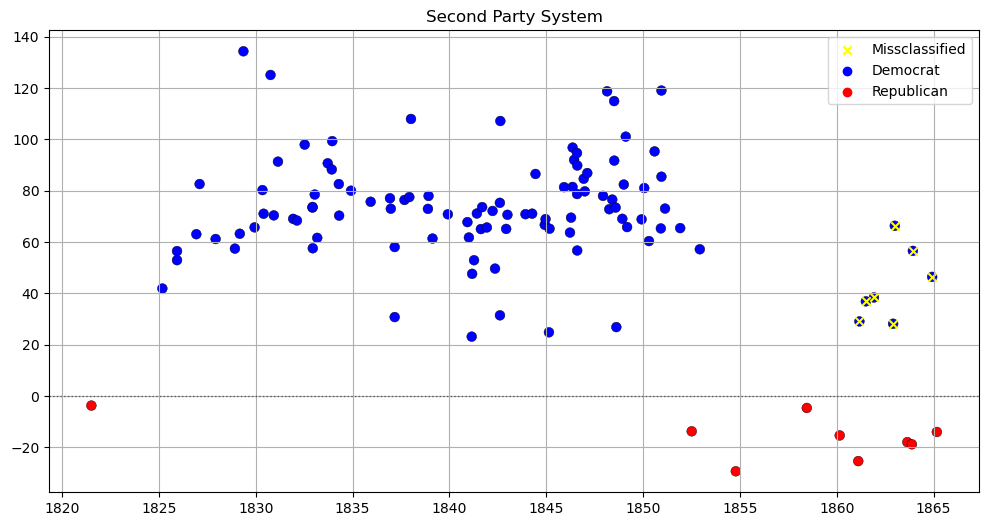

In [64]:
a11, demo11,repub11 = fightin_change(second_party, sixth_party, v=vectorizer)
secondparty, wrongsecond = fightin_scoring_plot(second_party, demo11, repub11, "Second Party System")

In [65]:
a12, demo12,repub12 = fightin_change(first_party, sixth_party, v=vectorizer)


Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 19542
Comparing language...
Top terms in Democrat
zte         0.000
exams       0.000
examination  0.000
examinations  0.000
examine     0.000
examined    0.000
examining   0.000
example     0.000
examples    0.000
exasperating  0.000

Top terms in Republican
00          0.000
plummet     0.000
plumbers    0.000
plumb       0.000
plug        0.000
ploy        0.000
plowshares  0.000
plowed      0.000
plouffe     0.000
plotting    0.000


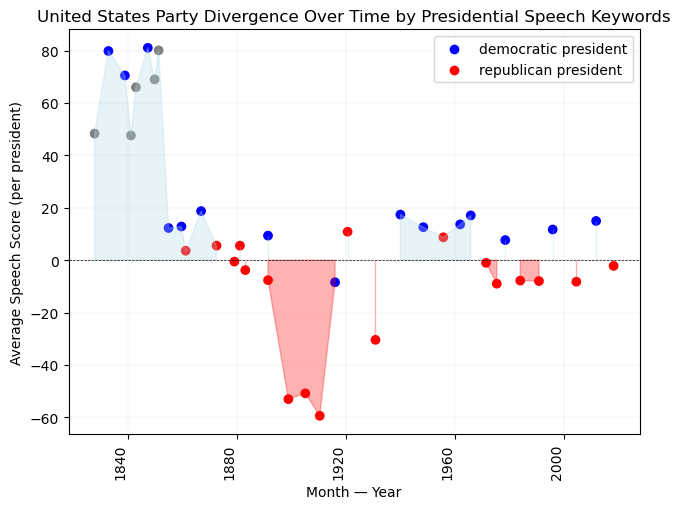

In [66]:
#agg change over time
totalscores = pd.concat([sixpartydf, fivepartydf, fourthpartydf, thirdpartydf, secondparty], ignore_index=True)

total_dem = totalscores[totalscores['party'] == 'Democratic']
total_rep = totalscores[totalscores['party'] == 'Republican']

all_avg = totalscores.groupby(['president','party'])[['score', 'date']].mean()

all_avg.reset_index(inplace=True)

party_colors = {
    'Republican': 'red',
    'Democratic': 'blue',
}

all_avg = all_avg.sort_values(by='date')

demall = all_avg[all_avg['party'] == 'Democratic']

repall = all_avg[all_avg['party'] == 'Republican']



plt.scatter(all_avg['date'], all_avg['score'], c=all_avg['party'].map(party_colors).fillna('gray'))

plt.scatter([], [], c='b', alpha=1, label='democratic president') #just for labels
plt.scatter([], [], c='r', alpha=1, label='republican president') #just for labels

plt.xticks(rotation=90, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
plt.grid(True,  linewidth=.1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5) 
plt.fill_between(all_avg['date'], all_avg['score'], 0, where=all_avg['score'] > 0, color='lightblue', alpha=0.3)
plt.fill_between(all_avg['date'], all_avg['score'], 0, where=all_avg['score'] < 0, color='red', alpha=0.3)
plt.title("United States Party Divergence Over Time by Presidential Speech Keywords")
plt.ylabel("Average Speech Score (per president)")
plt.xlabel("Month — Year")
plt.legend()



Text(0.5, 1.0, 'Republican Speeches by Score')

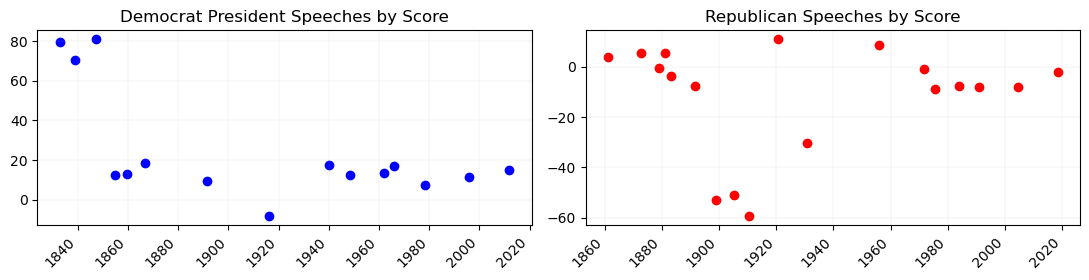

In [67]:
plt.figure(figsize=(11,5))

plt.subplot(2,2,1)
plt.scatter(demall['date'], demall['score'], c='b', alpha=1, label='democratic president')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout()
plt.grid(True, linewidth=.1)
plt.title('Democrat President Speeches by Score')

# plt.plot(demall['date'], poly(x_all), color='green', label='Linear Regression', linewidth = .5, linestyle='--')


plt.subplot(2,2,2)
plt.scatter(repall['date'], repall['score'], c='r', alpha=1, label='republican president')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
plt.grid(True, linewidth = .1)
plt.title('Republican Speeches by Score')

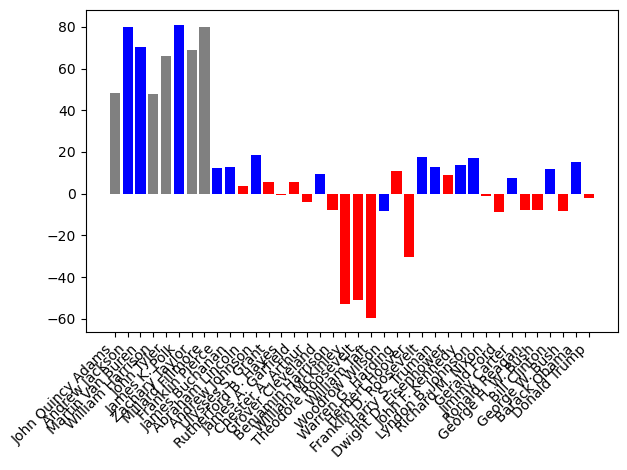

In [68]:
plt.bar(all_avg['president'], all_avg['score'], color='gray')
plt.bar(demall['president'], demall['score'], color='blue')
plt.bar(repall['president'], repall['score'], color='red')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 

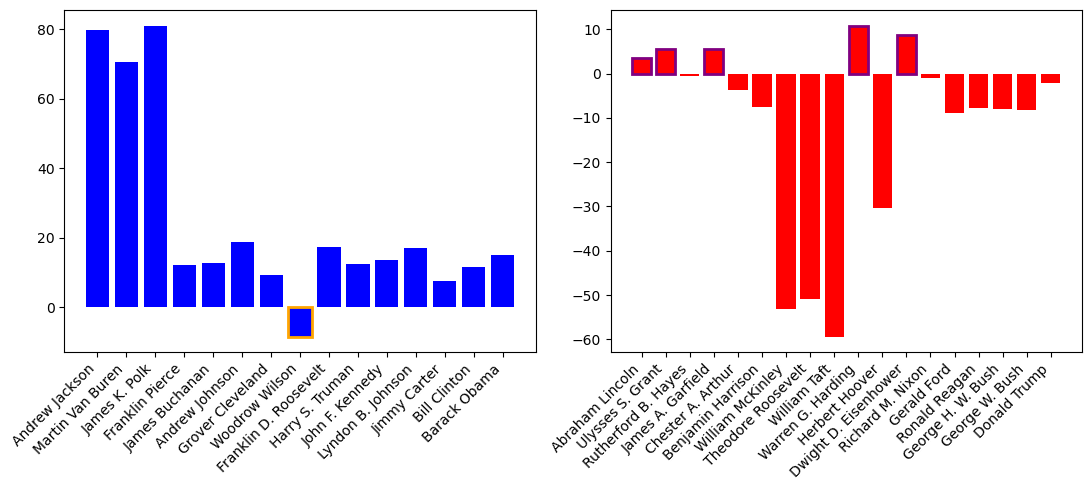

In [69]:
plt.figure(figsize=(11,5))


demall = demall.sort_values(by='date')
plt.subplot(121)
dembar = plt.bar(demall['president'], demall['score'], color='blue')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
for i, bar in enumerate(dembar):
    if demall['score'].values[i] < 0:
        bar.set_edgecolor('orange')
        bar.set_linewidth(2)

plt.subplot(122)
repbar = plt.bar(repall['president'], repall['score'], color='red')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
for i, bar in enumerate(repbar):
    if repall['score'].values[i] > 0:
        bar.set_edgecolor('purple')
        bar.set_linewidth(2)



In [70]:
## misclassified presidents in both parties
incorrect_rep_avg = repall[repall['score'] > 0]
incorrect_dem_avg = demall[demall['score'] < 0]

##number of misclassified rep speeches total
lenrep = len(total_rep)
rep_all_wrong = (total_rep['score'] > 0).sum()

##number of misclassified dem speeches total
lendem = len(total_dem)
dem_all_wrong = (total_dem['score'] < 0).sum()


incorrect_rep_avg




,president,party,score,date
0,Abraham Lincoln,Republican,3.607650,1861-04-10 09:36:00
31,Ulysses S. Grant,Republican,5.550889,1872-07-24 17:15:00
17,James A. Garfield,Republican,5.541281,1881-03-04 00:00:00
32,Warren G. Harding,Republican,10.854980,1920-09-09 09:20:00
8,Dwight D. Eisenhower,Republican,8.724089,1955-10-31 00:00:00


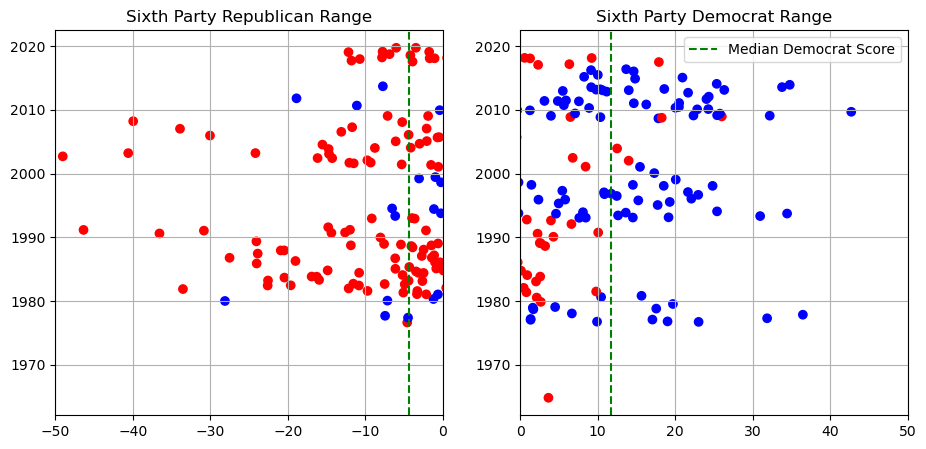

In [184]:
plt.figure(figsize=(11,5))

plt.subplot(121)
plt.scatter(sixpartydf['score'], sixpartydf['date'], c=sixpartydf['party'].map(party_colors).fillna('gray'))
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Democratic', color='lightblue', alpha=0.3)
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Republican', color='red', alpha=0.3)
plt.xlim(-50, 0)
median_republican_score = np.median(sixpartydf[sixpartydf['party'] == 'Republican']['score'])

# Plot median line
plt.axvline(x=median_republican_score, color='green', linestyle='--', label='Median Republican Score')
plt.title("Sixth Party Republican Range")
plt.grid(True)


plt.subplot(122)
plt.scatter(sixpartydf['score'], sixpartydf['date'], c=sixpartydf['party'].map(party_colors).fillna('gray'))
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Democratic', color='lightblue', alpha=0.3)
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Republican', color='red', alpha=0.3)
plt.xlim(0, 50)
median_democrat_score = np.median(sixpartydf[sixpartydf['party'] == 'Democratic']['score'])

# Plot median line
plt.axvline(x=median_democrat_score, color='green', linestyle='--', label='Median Democrat Score')
plt.title("Sixth Party Democrat Range")
plt.grid(True)
plt.legend()

In [187]:
median_democrat_score = np.median(totalscores[totalscores['party'] == 'Democratic']['score'])

median_republican_score = np.median(totalscores[totalscores['party'] == 'Republican']['score'])


print(median_democrat_score, median_republican_score)

15.45784823064852 -6.87947110968218


In [189]:
import numpy as np

# Extract scores for the Democratic party
democratic_scores = totalscores[totalscores['party'] == 'Republican']['score']

# Calculate skewness
skewness = np.mean((democratic_scores - np.mean(democratic_scores))**3) / np.std(democratic_scores)**3

print("Skewness of Democratic scores:", skewness)

Skewness of Democratic scores: -1.026836715803981


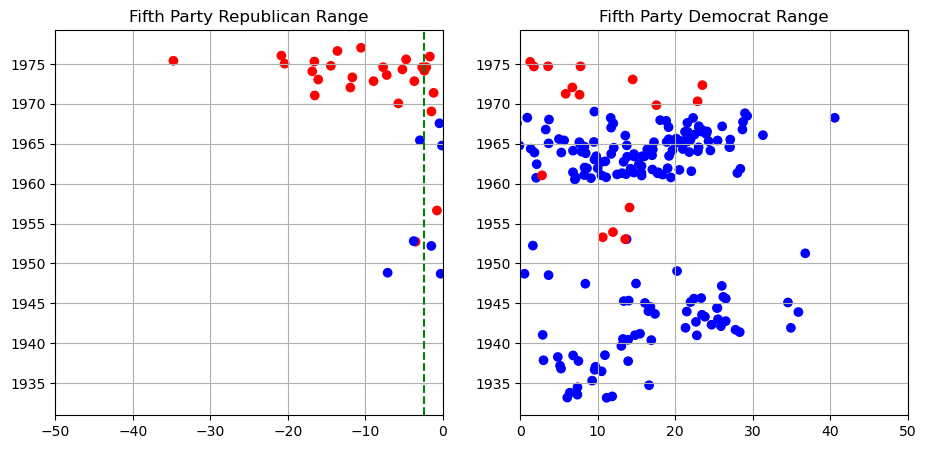

In [113]:
plt.figure(figsize=(11,5))

plt.subplot(121)
plt.scatter(fivepartydf['score'], fivepartydf['date'], c=fivepartydf['party'].map(party_colors).fillna('gray'))
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Democratic', color='lightblue', alpha=0.3)
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Republican', color='red', alpha=0.3)
plt.xlim(-50, 0)
median_republican_score = np.median(fivepartydf[fivepartydf['party'] == 'Republican']['score'])

# Plot median line
plt.axvline(x=median_republican_score, color='green', linestyle='--', label='Median Republican Score')
plt.title("Fifth Party Republican Range")
plt.grid(True)


plt.subplot(122)
plt.scatter(fivepartydf['score'], fivepartydf['date'], c=fivepartydf['party'].map(party_colors).fillna('gray'))
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Democratic', color='lightblue', alpha=0.3)
# plt.fill_between(sixpartydf['score'], sixpartydf['date'], 0, where=sixpartydf['party'] == 'Republican', color='red', alpha=0.3)
plt.xlim(0, 50)
median_democrat_score = np.median(fivepartydf[fivepartydf['party'] == 'Democrat']['score'])

# Plot median line
plt.axvline(x=median_democrat_score, color='green', linestyle='--', label='Median Democrat Score')
plt.title("Fifth Party Democrat Range")
plt.grid(True)

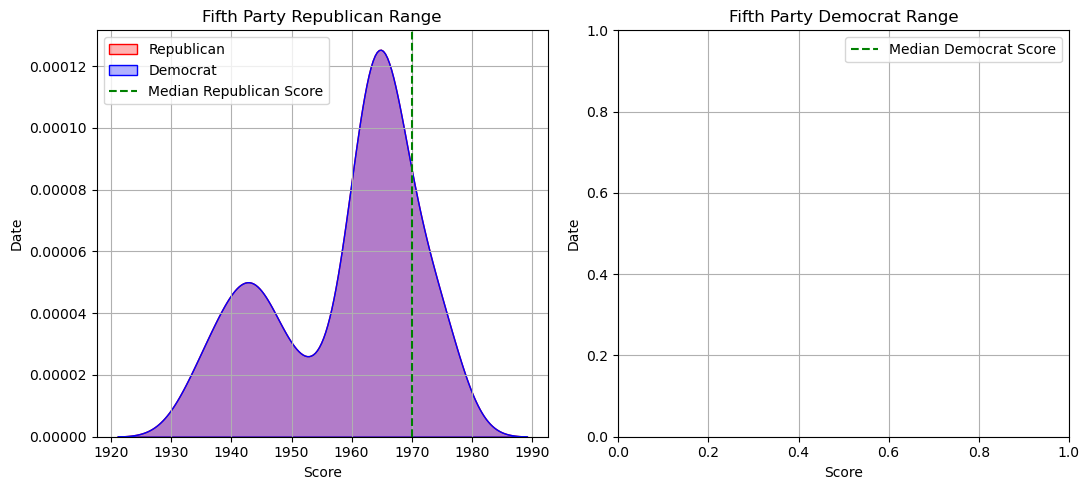

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define colors for parties
party_colors = {'Democratic': 'blue', 'Republican': 'red'}

plt.figure(figsize=(11, 5))

# Subplot 1: Scores <= 0
plt.subplot(121)
scores_republican = fivepartydf[fivepartydf['party'] == 'Republican']['score']
sns.kdeplot(fivepartydf[fivepartydf['party'] == 'Republican']['score'], x=fivepartydf['date'], color='red', fill=True, label='Republican', alpha=0.3)
sns.kdeplot(fivepartydf[fivepartydf['party'] == 'Democrat']['score'], x=fivepartydf['date'], color='blue', fill=True, label='Democrat', alpha=0.3)

# Calculate median score for Republican party
median_republican_score = np.median(scores_republican)
plt.axvline(x=median_republican_score, color='green', linestyle='--', label='Median Republican Score')
plt.grid(True)
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('Fifth Party Republican Range')
plt.legend()

# Subplot 2: Scores > 0
plt.subplot(122)
scores_democrat = fivepartydf[fivepartydf['party'] == 'Democrat']['score']


# Calculate median score for Democrat party
median_democrat_score = np.median(scores_democrat)
plt.axvline(x=median_democrat_score, color='green', linestyle='--', label='Median Democrat Score')
plt.grid(True)
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('Fifth Party Democrat Range')
plt.legend()

plt.tight_layout()
plt.show()


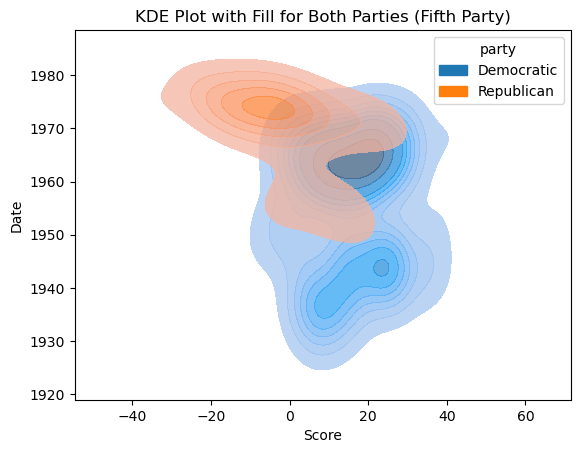

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = fivepartydf[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha = .75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Fifth Party)')

# Show the plot
plt.show()


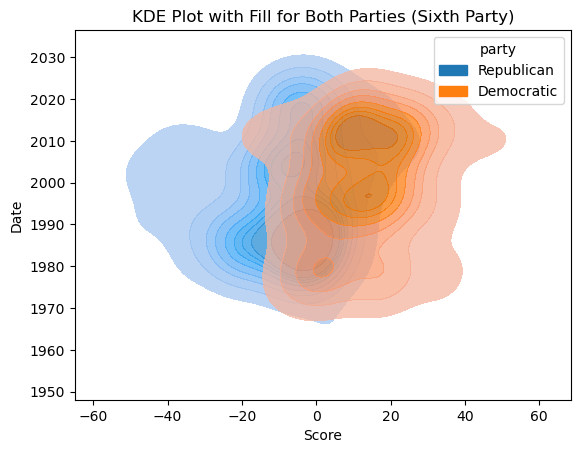

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = sixpartydf[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Sixth Party)')

# Show the plot
plt.show()


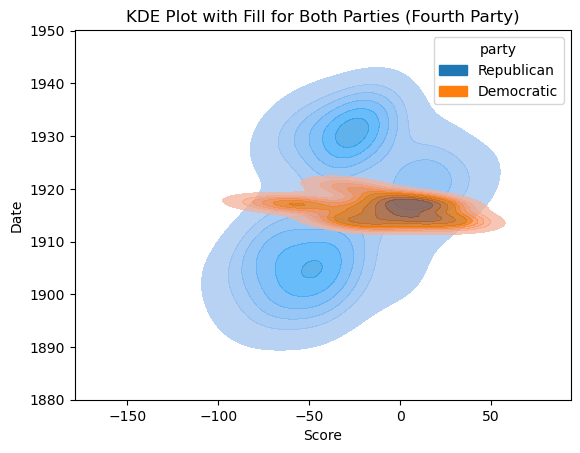

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = fourthpartydf[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Fourth Party)')

# Show the plot
plt.show()


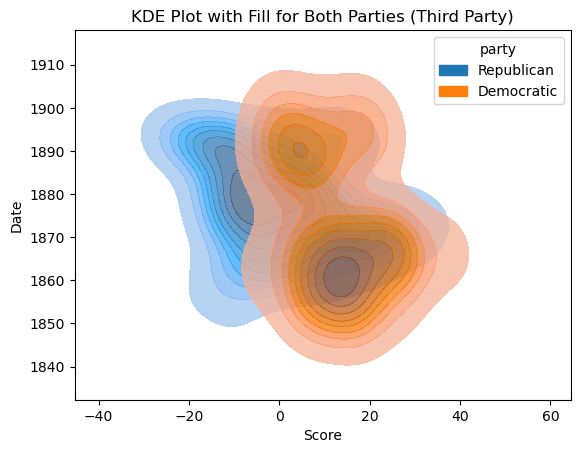

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = thirdpartydf[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Third Party)')

# Show the plot
plt.show()

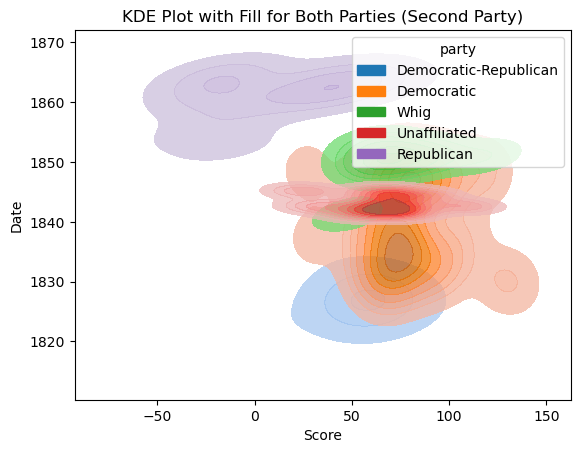

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = secondparty[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Second Party)')

# Show the plot
plt.show()

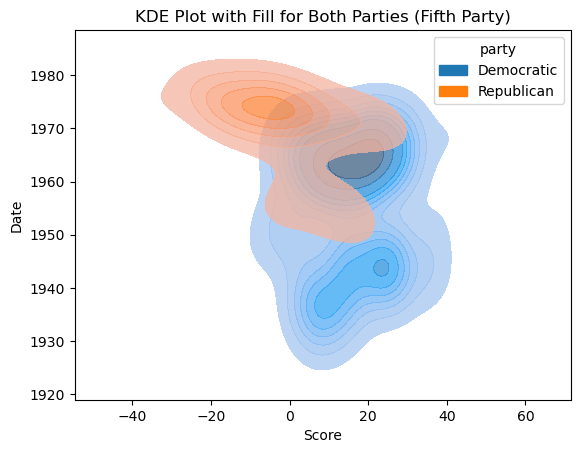

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = fivepartydf[['score', 'party', 'date']]

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Fifth Party)')

# Show the plot
plt.show()

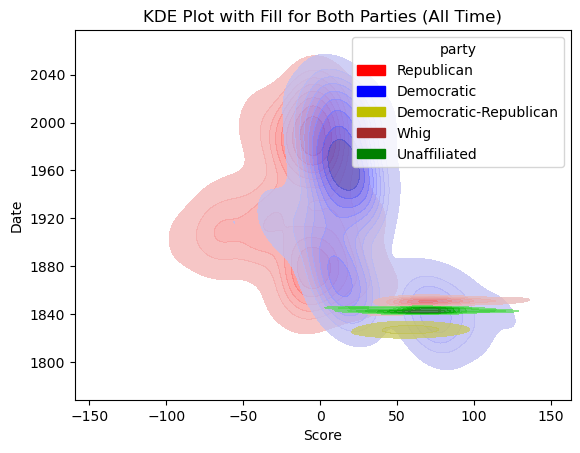

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = totalscores[['score', 'party', 'date']]
map = {'Republican':'r', 'Democratic':'b', 'Unaffiliated':'g', 'Democratic-Republican':'y', 'Whig':'brown'}

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.75, palette=map)


# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (All Time)')

# Show the plot
plt.show()

In [195]:
maximum_score_republican = demall['score'].max()
print("Maximum score among Republicans:", maximum_score_republican)

Maximum score among Republicans: 0.8307581543922424


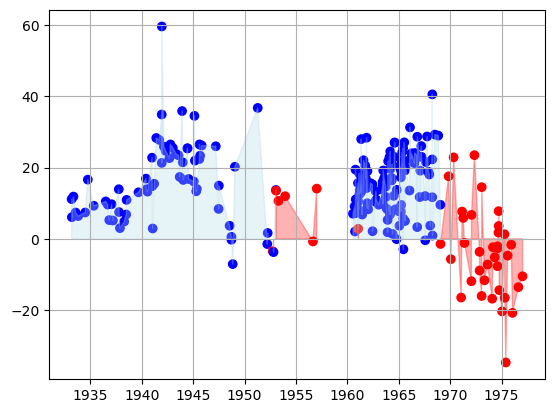

In [240]:
plt.scatter(fivepartydf['date'], fivepartydf['score'], c=fivepartydf['party'].map(party_colors).fillna('gray'))
plt.fill_between(fivepartydf['date'], fivepartydf['score'], 0, where=fivepartydf['party'] == 'Democratic', color='lightblue', alpha=0.3)
plt.fill_between(fivepartydf['date'], fivepartydf['score'], 0, where=fivepartydf['party'] == 'Republican', color='red', alpha=0.3)
plt.grid(True)

### Era Specific (Assuming Prior is the Party Itself)

In [239]:
vectorizer = CountVectorizer( # set up a vectorizer
    lowercase=True,
    strip_accents='unicode',
    input='content',
    encoding='utf-8',
    stop_words = 'english'
)

def fightin_change_silo(party_system, prior_train, v= vectorizer): 
    '''
    Returns party divergence given general prior, and training systems. DOES NOT include plotting
    Arguments: 
    - party_system: The party system that is to be analyzed
    - prior_train: The party system to train on
    - v=vectorizer: The vectorizer being used
    '''
    speeches1 = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in party_system]
    parties = [party for president, party in zip(speeches['President'], speeches['Party']) if president in party_system]
    #repub
    republican_speeches = [speech for speech, party in zip(speeches1, parties) if party == 'Republican']
    #dem
    democrat_speeches = [speech for speech, party in zip(speeches1, parties) if party == 'Democratic']
    #prior
    xprior = [speech for president, speech in zip(speeches['President'], speeches['Transcript']) if president in prior_train]
    priors = np.sum(v.fit_transform(xprior), axis=0).reshape(-1,1) #initially fit on prior speeches

    #matrix intialization for features: 
        #republican
    republican_matrix = v.transform(republican_speeches)
    republican_aggregated = np.sum(republican_matrix, axis=0)  # You can also use np.mean() if needed
    rr = republican_aggregated.reshape(1, -1)
        #democrat
    democrat_matrix = v.transform(democrat_speeches)
    democrat_aggregated = np.sum(democrat_matrix, axis=0)  # You can also use np.mean() if needed
    dr = democrat_aggregated.reshape(1, -1)
        #aggregate
    party_matrix = np.vstack([dr, rr])
    print(f"Shape: {party_matrix.shape}, 2 parties by total vocab size")

    #express results
    informative = fw.bayes_compare_language(democrat_speeches, republican_speeches)
    display_fw(informative, name1= "Democrat", name2 = "Republican")

    #scoring
        #initialize dem dict
    dem_dict = {term: score for term, score in reversed(informative[-200:])}

        #initialize repub dict
    repub_dict = {term: score for term, score in reversed(informative[:200])}

    return party_matrix, dem_dict, repub_dict

##can still use fightin_scoring_plot

Shape: (2, 19542), 2 parties by total vocab size
Vocab size is 4263
Comparing language...
Top terms in Democrat
health     12.831
insurance  11.245
businesses 11.237
energy     10.861
carter     10.790
college    10.732
ford        9.529
education   9.472
oil         9.372
governor    8.930

Top terms in Republican
soviet     -11.031
terrorists -8.321
iraqi      -8.309
iraq       -8.297
missiles   -8.034
border     -7.729
bush       -7.487
terror     -7.467
regime     -6.834
lebanon    -6.725


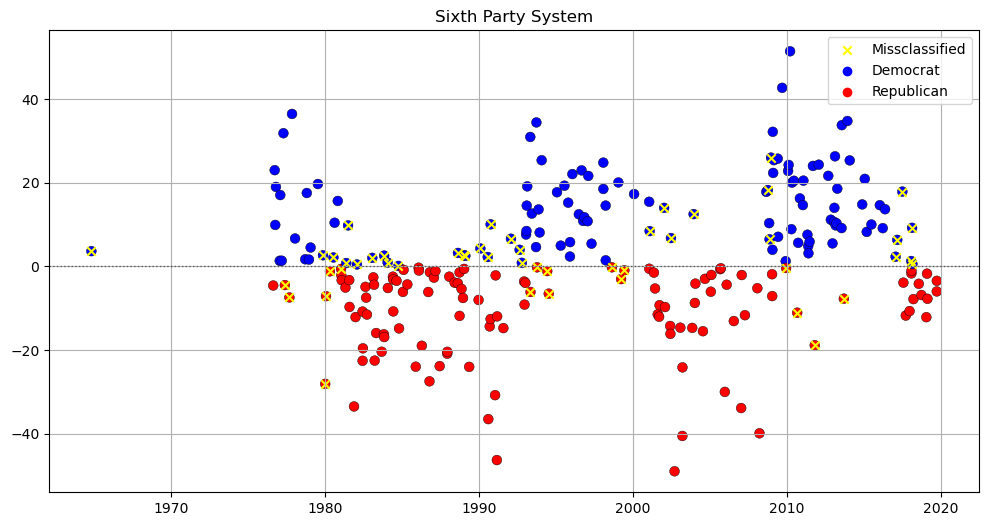

In [254]:
p ,demo,repu = fightin_change_silo(sixth_party, sixth_party, v=vectorizer)
sixpartydf, wrongsix = fightin_scoring_plot(sixth_party, demo, repu, "Sixth Party System")

Shape: (2, 16155), 2 parties by total vocab size
Vocab size is 3436
Comparing language...
Top terms in Democrat
bill        5.721
rights      5.327
attack      5.152
labor       4.839
democracy   4.758
women       4.739
democratic  4.568
civil       4.559
germany     4.558
space       4.439

Top terms in Republican
energy     -16.426
oil        -10.461
inflation  -10.155
goal       -8.925
withdrawal -8.609
americas   -8.330
mutual     -8.299
negotiations -7.898
involvement -7.827
actions    -7.609


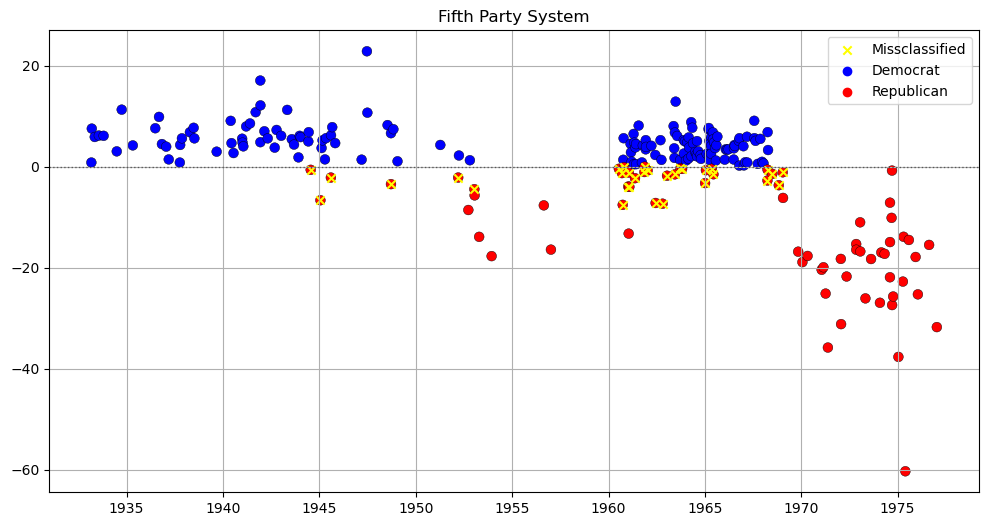

In [244]:
##fifth party test
p ,demo,repu = fightin_change_silo(fifth_party, fifth_party, v=vectorizer)
fivepartydf, wrongfive = fightin_scoring_plot(fifth_party, demo, repu, "Fifth Party System")

Shape: (2, 17749), 2 parties by total vocab size
Vocab size is 3444
Comparing language...
Top terms in Democrat
german     14.028
things     13.618
know       11.159
how        10.412
ready      10.127
liberty     9.708
counsel     9.667
processes   9.416
play        9.284
circumstances  9.211

Top terms in Republican
department -5.630
republic   -5.307
increase   -5.108
panama     -4.902
treaty     -4.854
canal      -4.738
court      -4.677
countries  -4.551
progress   -4.409
per        -4.363


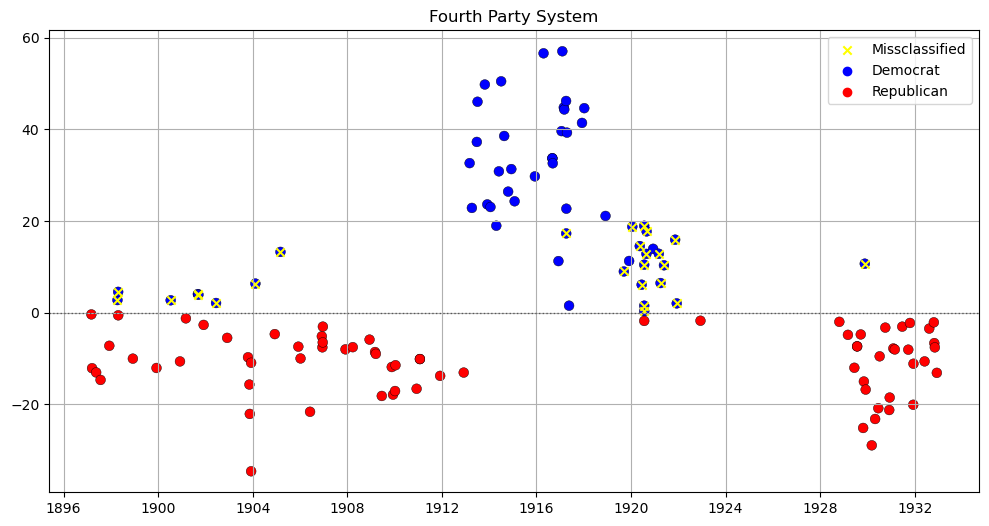

In [246]:
p ,demo,repu = fightin_change_silo(fourth_party, fourth_party, v=vectorizer)
fourpartydf, wrongfour = fightin_scoring_plot(fourth_party, demo, repu, "Fourth Party System")

Shape: (2, 18304), 2 parties by total vocab size
Vocab size is 4329
Comparing language...
Top terms in Democrat
examination  9.964
kansas      9.336
gold        8.153
classified  8.065
person      7.884
legislative  7.447
rule        7.228
notes       7.025
objects     6.788
rebellion   6.747

Top terms in Republican
slavery    -10.784
missouri   -8.541
trade      -8.336
you        -8.336
nebraska   -7.811
slave      -7.686
lines      -7.550
compromise -7.545
about      -7.268
products   -7.249


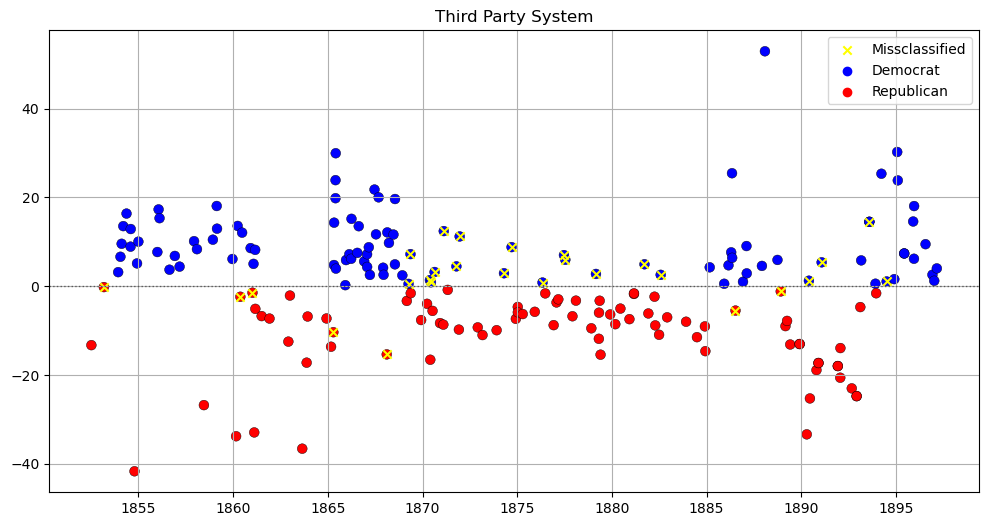

In [249]:
p ,demo,repu = fightin_change_silo(third_party, third_party, v=vectorizer)
thirdpartydf, wrongfour = fightin_scoring_plot(third_party, demo, repu, "Third Party System")

Shape: (2, 13997), 2 parties by total vocab size
Vocab size is 2239
Comparing language...
Top terms in Democrat
treasury    7.446
mexico      7.393
revenue     6.847
treaty      6.759
system      6.291
banks       5.951
officers    5.619
commerce    5.502
lands       5.126
mexican     4.910

Top terms in Republican
slavery    -18.155
missouri   -15.016
man        -14.402
say        -13.851
compromise -13.700
let        -12.247
did        -12.030
slave      -11.897
go         -11.304
north      -11.250


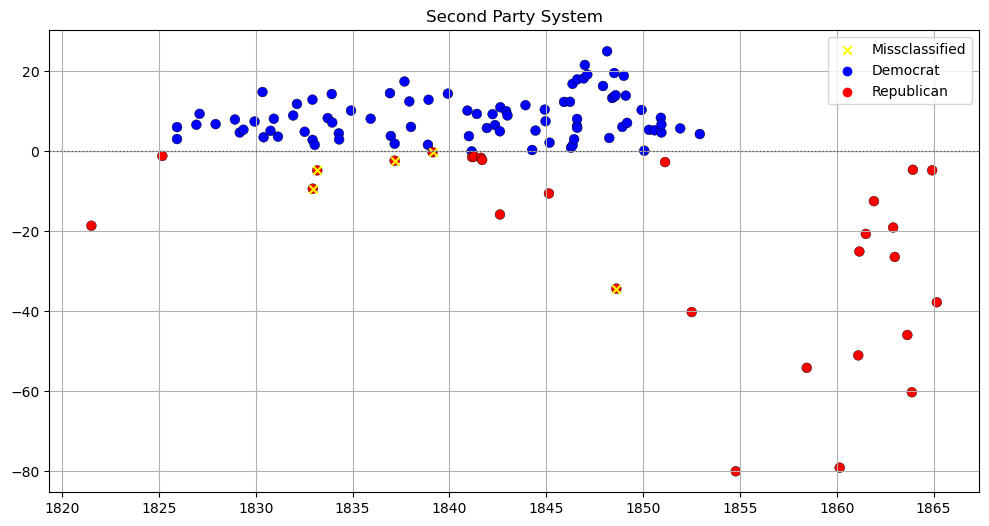

In [251]:
p ,demo,repu = fightin_change_silo(second_party, second_party, v=vectorizer)
secondpartydf, wrongfour = fightin_scoring_plot(second_party, demo, repu, "Second Party System")

In [259]:
totalscores_silo = pd.concat([sixpartydf, fivepartydf, fourthpartydf, thirdpartydf, secondpartydf], ignore_index=True)

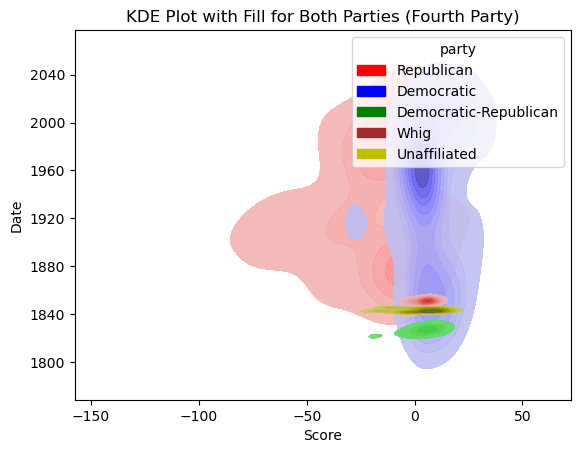

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for both parties
combined_data = totalscores_silo[['score', 'party', 'date']]

map = {'Republican':'r', 'Democratic':'b', 'Unaffiliated':'y', 'Democratic-Republican':'g', 'Whig':'brown'}

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party', fill=True, alpha=.9, palette=map)
# sns.lineplot(data=combined_data, x='date', y='score', hue='party', palette=map)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Fourth Party)')

# Show the plot
plt.show()

#### LDA

In [72]:
lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', random_state=42, batch_size=900)
lda_output = lda_model.fit_transform(output_matrix)
print(lda_model)

LatentDirichletAllocation(batch_size=900, learning_method='online',
                          n_components=5, random_state=42)


In [73]:
def show_topics(vectorizer=pre, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=pre, lda_model=lda_model, n_words=10)

# topic key words df
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i + 1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic ' + str(i + 1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,america,world,ve,new,nation,peace,know,israel,just,congress
Topic 2,congress,public,shall,state,year,war,law,treasury,000,general
Topic 3,world,american,new,state,war,congress,president,000,stem,america
Topic 4,world,congress,peace,president,shall,america,men,war,years,nation
Topic 5,ve,america,world,american,new,know,work,americans,iraq,going


In [74]:
# from umap import UMAP

# X_umap = UMAP().fit_transform(output_matrix)
# sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df['Party'], alpha=0.3)
# plt.show()

##### Word Embeddings (Pickles)

In [226]:
import pickle

#sixth party
with open('sixth.pickle', 'rb') as f:
    sixth_embed = pickle.load(f)

#fifth party
with open('fifth.pickle', 'rb') as f:
    fifth_embed = pickle.load(f)

#fourth party
with open('fourth.pickle', 'rb') as f:
    fourth_embed = pickle.load(f)

#third party
with open('third.pickle', 'rb') as f:
    third_embed = pickle.load(f)

#second party
with open('second.pickle', 'rb') as f:
    second_embed = pickle.load(f)

#embedding concat
total_embed = pd.concat([sixth_embed, fifth_embed, fourth_embed, third_embed, second_embed], ignore_index=True)

avg_embed = total_embed.groupby(['president','party'])[['score', 'date']].mean()
avg_embed = avg_embed.sort_values(by='date')
avg_embed.reset_index(inplace=True)

total_embed.reset_index(drop=True, inplace=True)

In [227]:
total_embed

,president,date,score,party
0,Ronald Reagan,1964-10-27,0.795129,Republican
1,Ronald Reagan,1976-08-19,0.764897,Republican
2,Jimmy Carter,1976-09-23,0.810974,Democratic
3,Jimmy Carter,1976-10-06,0.788813,Democratic
4,Jimmy Carter,1976-10-22,0.793601,Democratic
...,...,...,...,...
904,Abraham Lincoln,1863-08-26,0.783800,Republican
905,Abraham Lincoln,1863-11-19,0.771590,Republican
906,Abraham Lincoln,1863-12-08,0.838094,Republican
907,Abraham Lincoln,1864-12-06,0.836316,Republican


In [193]:
# Extract scores for the Democratic party
democratic_scores = total_embed[totalscores['party'] == 'Democratic']['score']

# Calculate skewness
skewness = np.mean((democratic_scores - np.mean(democratic_scores))**3) / np.std(democratic_scores)**3

print("Skewness of Democratic scores:", skewness)

Skewness of Democratic scores: -0.906204978573822


In [208]:
second_embed

,president,date,score,party
0,John Quincy Adams,1821-07-04,0.795811,Democratic-Republican
1,John Quincy Adams,1825-03-04,0.814333,Democratic-Republican
2,John Quincy Adams,1825-12-06,0.826815,Democratic-Republican
3,John Quincy Adams,1825-12-06,0.820217,Democratic-Republican
4,John Quincy Adams,1826-12-05,0.825475,Democratic-Republican
...,...,...,...,...
110,Abraham Lincoln,1863-08-26,0.783800,Republican
111,Abraham Lincoln,1863-11-19,0.771590,Republican
112,Abraham Lincoln,1863-12-08,0.838094,Republican
113,Abraham Lincoln,1864-12-06,0.836316,Republican


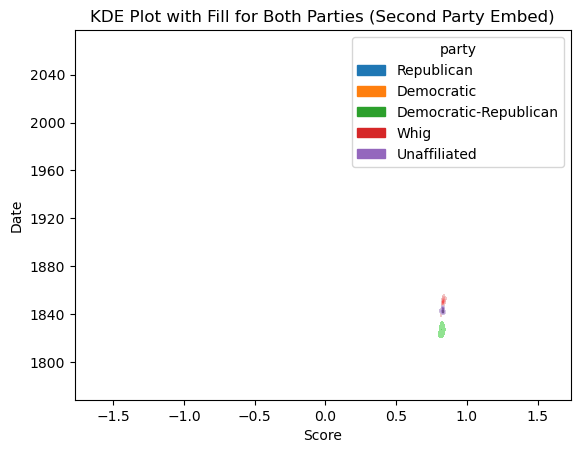

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

total_embed = pd.concat([sixth_embed, fifth_embed, fourth_embed, third_embed, second_embed], ignore_index=True)

# Combine data for both parties
combined_data = total_embed[['score', 'party', 'date']]

combined_data

# Create KDE plot with fill
sns.kdeplot(data=combined_data, x='score', y='date', hue='party',fill=True, alpha=.75)

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot with Fill for Both Parties (Second Party Embed)')

# plt.xlim(.75, 1.0)
# plt.ylim(100, 1880)

# Show the plot
plt.show()

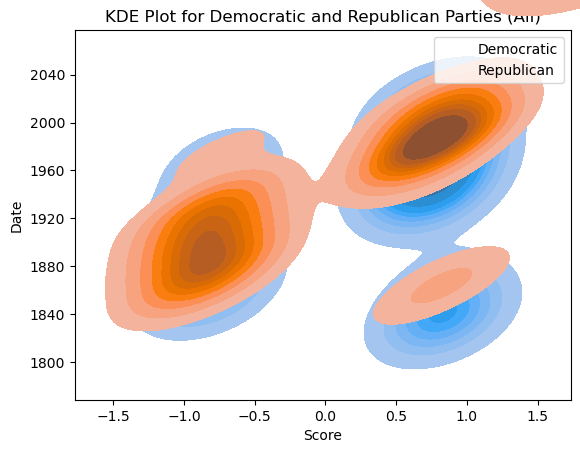

In [237]:
democratic_data = total_embed[total_embed['party'] == 'Democratic']
republican_data = total_embed[total_embed['party'] == 'Republican']
w_data = total_embed[total_embed['party'] == 'Whig']
dr_data = total_embed[total_embed['party'] == 'Democratic-Republican']
u_data = total_embed[total_embed['party'] == 'Unaffiliated']

# Plot KDE for Democratic party
sns.kdeplot(data=democratic_data, x='score', y='date', fill=True, label='Democratic')
# sns.kdeplot(data=dr_data, x='score', y='date', fill=True, label='Democratic-Republican')
# sns.kdeplot(data=w_data, x='score', y='date', fill=True, label='Whig')
# sns.kdeplot(data=u_data, x='score', y='date', fill=True, label='Unaffiliated')

# Plot KDE for Republican party
sns.kdeplot(data=republican_data, x='score', y='date', fill=True, label='Republican')

# Set labels and title
plt.xlabel('Score')
plt.ylabel('Date')
plt.title('KDE Plot for Democratic and Republican Parties (All)')
plt.legend()

<Axes: xlabel='date', ylabel='score'>

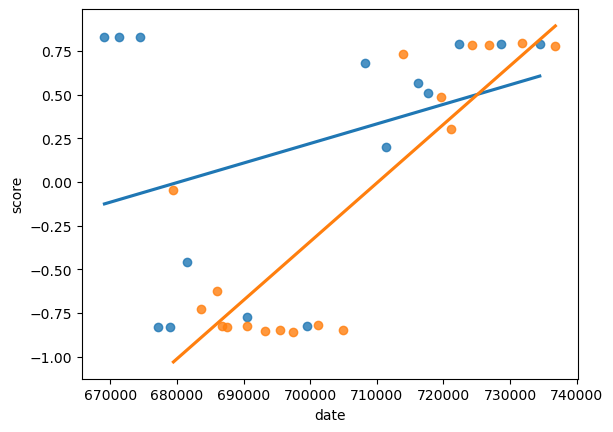

In [76]:
demall = avg_embed[avg_embed['party'] == 'Democratic']
demall['date'] = demall['date'].apply(lambda x: x.toordinal())

repall= avg_embed[avg_embed['party'] == 'Republican']
repall['date'] = repall['date'].apply(lambda x: x.toordinal())

# demall['year'] = demall['date'].dt.year

import seaborn as sns
sns.regplot(x=demall['date'], y=demall['score'], scatter=True, ci=None)
sns.regplot(x=repall['date'], y=repall['score'], scatter=True, ci=None)

Text(0.5, 1.0, 'Republican Speeches by Score')

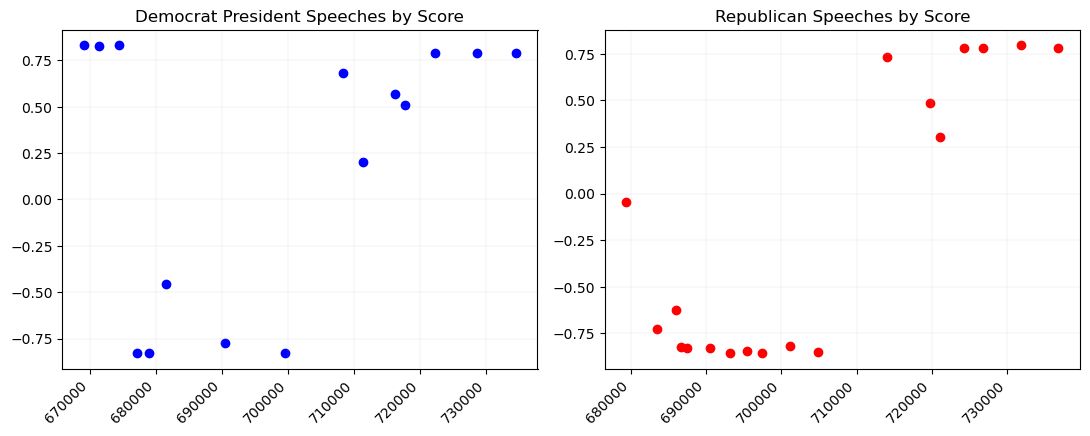

In [77]:
plt.figure(figsize=(11,8))

plt.subplot(2,2,1)
plt.scatter(demall['date'], demall['score'], c='b', alpha=1, label='democratic president')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout()
plt.grid(True, linewidth=.1)
plt.title('Democrat President Speeches by Score')

# plt.plot(demall['date'], poly(x_all), color='green', label='Linear Regression', linewidth = .5, linestyle='--')


plt.subplot(2,2,2)
plt.scatter(repall['date'], repall['score'], c='r', alpha=1, label='republican president')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
plt.grid(True, linewidth = .1)
plt.title('Republican Speeches by Score')

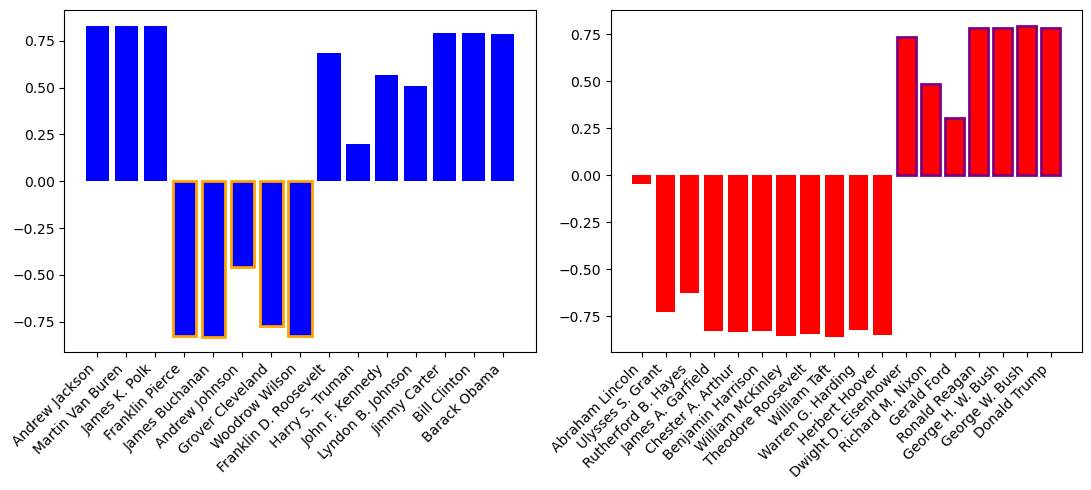

In [78]:
plt.figure(figsize=(11,5))


demall = demall.sort_values(by='date')
plt.subplot(121)
dembar = plt.bar(demall['president'], demall['score'], color='blue')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
for i, bar in enumerate(dembar):
    if demall['score'].values[i] < 0:
        bar.set_edgecolor('orange')
        bar.set_linewidth(2)

plt.subplot(122)
repbar = plt.bar(repall['president'], repall['score'], color='red')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
for i, bar in enumerate(repbar):
    if repall['score'].values[i] > 0:
        bar.set_edgecolor('purple')
        bar.set_linewidth(2)

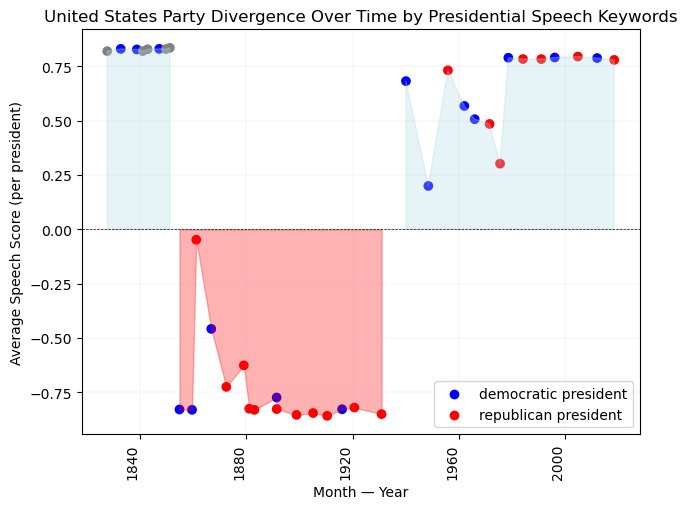

In [79]:

plt.scatter(avg_embed['date'], avg_embed['score'], c=avg_embed['party'].map(party_colors).fillna('gray'))

plt.scatter([], [], c='b', alpha=1, label='democratic president') #just for labels
plt.scatter([], [], c='r', alpha=1, label='republican president') #just for labels

plt.xticks(rotation=90, ha='right')  # Rotate labels and align them to the right
plt.tight_layout() 
plt.grid(True,  linewidth=.1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5) 
plt.fill_between(avg_embed['date'], avg_embed['score'], 0, where=avg_embed['score'] > 0, color='lightblue', alpha=0.3)
plt.fill_between(avg_embed['date'], avg_embed['score'], 0, where=avg_embed['score'] < 0, color='red', alpha=0.3)
plt.title("United States Party Divergence Over Time by Presidential Speech Keywords")
plt.ylabel("Average Speech Score (per president)")
plt.xlabel("Month — Year")
plt.legend()

In [80]:
total_dem = total_embed[total_embed['party'] == 'Democratic']
total_rep = total_embed[total_embed['party'] == 'Republican']

##number of misclassified rep speeches total
lenrep = len(total_rep)
rep_all_wrong = (total_rep['score'] > 0).sum()

##number of misclassified dem speeches total
lendem = len(total_dem)
dem_all_wrong = (total_dem['score'] < 0).sum()

In [81]:
rep_all_wrong/lenrep

0.4923469387755102